In [126]:
import nibabel as nib
import numpy as np
import os
import glob
import h5py
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
import skimage
import lpips
import piq
import torch
import pywt

In [54]:
def compute_lpips(img1, img2):
    loss_fn = lpips.LPIPS(net='vgg')
    d = loss_fn.forward(img1, img2)
    return d

In [27]:
def compute_msssim(img1, img2):
    ms_ssim_index = piq.multi_scale_ssim(img1, img2, data_range=1.)
    return ms_ssim_index

In [10]:
def norm(img):
    img = (img - img.min()) / (img.max() - img.min())
    return np.clip(img, a_min=0.0, a_max=1.0)

In [59]:
def norm2(img):
    img = (img - img.mean()) / img.std()
    img = (img - img.min()) / (img.max() - img.min())
    return np.clip(img, a_min=0.0, a_max=1.0)

In [16]:
nib.load("/data/jiaqiw01/all_exp_tests/score-unet_lowdose_2_full/25013/pred.nii").get_fdata().shape

(256, 256, 89)

In [161]:
def get_histogram(data, num_bins=64, scale=10, output='norm'):
     # calculate histogram
    histograms, _ = np.histogram(data, bins=num_bins, range=(0.001, 1))
    normalized_histograms = histograms / (histograms.sum(keepdims=True) + 1e-4)
    normalized_histograms *= scale
    if output == 'norm':
        return normalized_histograms
    cum_hist = np.cumsum(normalized_histograms)
    hist_diff = np.diff(normalized_histograms)
    hist_diff = np.insert(hist_diff, 0, hist_diff[0])
    hist_diff *= scale
    combined_histogram = np.stack((normalized_histograms, cum_hist, hist_diff), axis=0) # 3, 128
    # assert combined_histogram.shape == (3, 128)
    return combined_histogram
    
def compare_histograms(vol1, vol2, num_bins=128):
    hist1 = get_histogram(vol1, num_bins, output='all')[0]
    hist2 = get_histogram(vol2, num_bins, output='all')[0]
    # chi-square, may give nan value
    from scipy.stats import chisquare, wasserstein_distance
    # chi_square, p_value = chisquare(hist1, hist2)
    # print(chi_square, p_value)
    # Wasserstein distance
    plt.subplot(121)
    plt.bar(range(num_bins), hist1, width=3)
    plt.subplot(122)
    plt.bar(range(num_bins), hist2, width=3)
    plt.show()
    emd = wasserstein_distance(hist1, hist2)
    print(f'EMD: {emd}')

In [166]:
slice_true = norm2(nib.load("/data/jiaqiw01/preprocessed_cases/25013/reslice_PET_full.nii").get_fdata())[:, :, 20:71]
slice_pred_1 = norm2(nib.load("/data/jiaqiw01/all_exp_tests/bbdm_pet_lowdose_hist_cond/25013/postprocessed_pet.nii").get_fdata())[:, :, 20:71]
slice_pred_2 = norm2(nib.load("/data/jiaqiw01/all_exp_tests/score_vpsde_dds_step_100/25013_pred.nii").get_fdata())[:, :, 20:71]
slice_pred_3 = norm2(nib.load("/data/jiaqiw01/all_exp_tests/test_cases_zerodose2/25013/pred.nii").get_fdata())[:, :, 20:71]

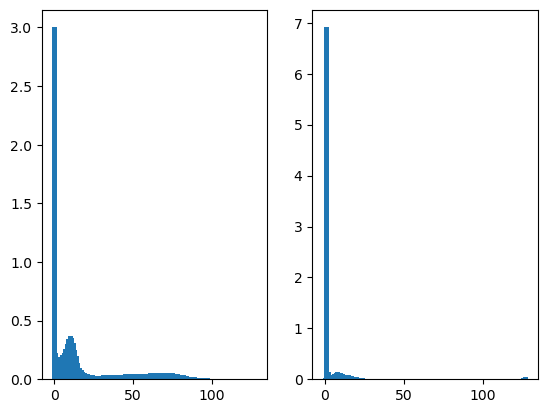

EMD: 0.065077702950078


In [167]:
compare_histograms(slice_true, slice_pred_1)

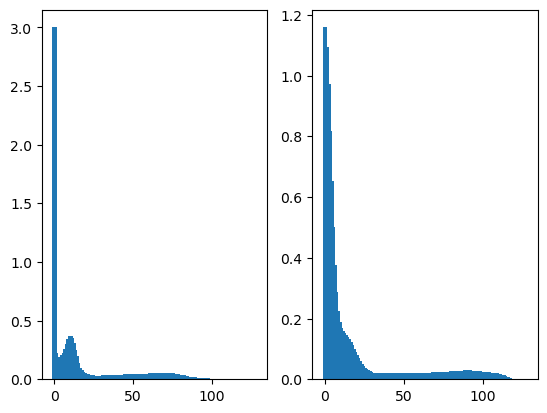

EMD: 0.04800971190456178


In [168]:
compare_histograms(slice_true, slice_pred_2)

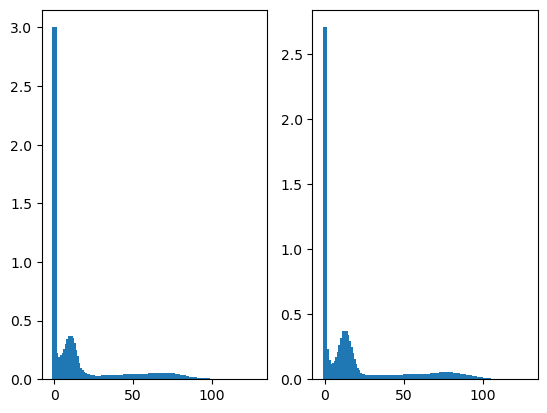

EMD: 0.009035769749060035


In [169]:
compare_histograms(slice_true, slice_pred_3)

In [152]:
def wavelet_transform(img, img2):
    titles = ['img', 'Approximation', ' Horizontal detail',
              'Vertical detail', 'Diagonal detail']
    coeffs1 = pywt.dwt2(img, 'db1')
    coeffs2 = pywt.dwt2(img2, 'db1')
    LL, (LH, HL, HH) = coeffs2
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([img, LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 5, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([img, LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 5, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    plt.show()

    def euclidean_distance(c1, c2):
        print(np.array(c1).shape)
        print(np.array(c2).shape)
        return np.linalg.norm(np.array(c1) - np.array(c2))
    
    distances = [euclidean_distance(c1, c2) for c1, c2 in zip(coeffs1, coeffs2)]
    print(f'Euclidean Distances: {distances}')



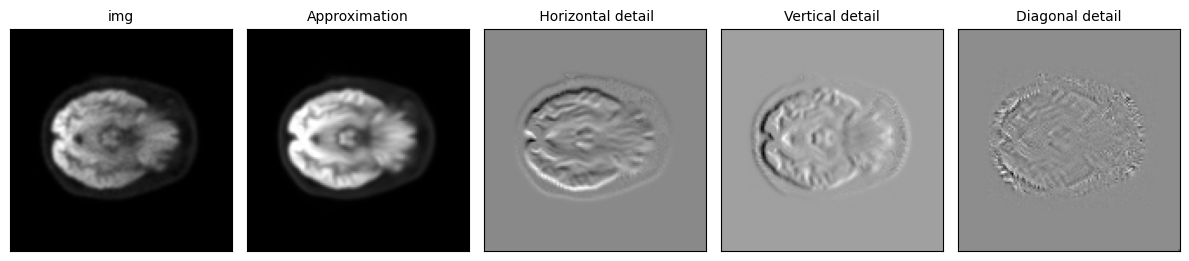

(128, 128)
(128, 128)
(3, 128, 128)
(3, 128, 128)
Euclidean Distances: [21.71160263221133, 1.5137808951834533]


In [153]:
wavelet_transform(slice_true, slice_pred_1)

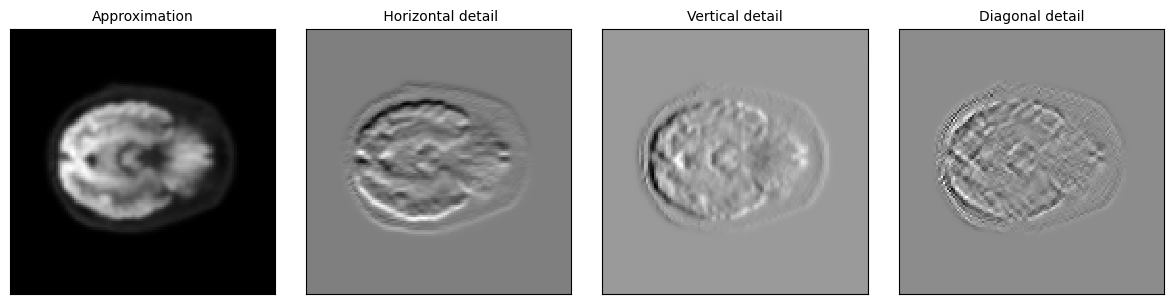

(128, 128)
(128, 128)
(3, 128, 128)
(3, 128, 128)
Euclidean Distances: [7.52144542546114, 1.2510505809819907]


In [149]:
wavelet_transform(slice_true, slice_pred_3)

Text(0.5, 1.0, 'UNet')

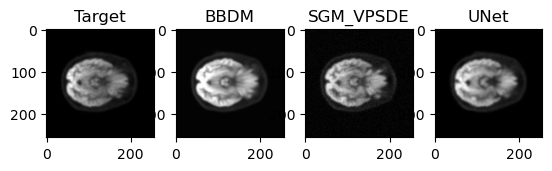

In [64]:
plt.subplot(141)
plt.imshow(slice_true, cmap='gray')
plt.title("Target")
plt.subplot(142)
plt.imshow(slice_pred_1, cmap='gray')
plt.title("BBDM")
plt.subplot(143)
plt.imshow(slice_pred_2, cmap='gray')
plt.title("SGM_VPSDE")
plt.subplot(144)
plt.imshow(slice_pred_3, cmap='gray')
plt.title("UNet")

In [65]:
s1 = compute_msssim(torch.Tensor(slice_true).reshape(1, 1, 256, 256), torch.Tensor(slice_pred_1).reshape(1, 1, 256, 256))
s2 = compute_msssim(torch.Tensor(slice_true).reshape(1, 1, 256, 256), torch.Tensor(slice_pred_2).reshape(1, 1, 256, 256))
s3 = compute_msssim(torch.Tensor(slice_true).reshape(1, 1, 256, 256), torch.Tensor(slice_pred_3).reshape(1, 1, 256, 256))
s1, s2, s3

(tensor(0.9430), tensor(0.9121), tensor(0.9684))

In [66]:
s1 = compute_lpips(torch.Tensor(slice_true).reshape(1, 1, 256, 256), torch.Tensor(slice_pred_1).reshape(1, 1, 256, 256))
s2 = compute_lpips(torch.Tensor(slice_true).reshape(1, 1, 256, 256), torch.Tensor(slice_pred_2).reshape(1, 1, 256, 256))
s3 = compute_lpips(torch.Tensor(slice_true).reshape(1, 1, 256, 256), torch.Tensor(slice_pred_3).reshape(1, 1, 256, 256))
s1, s2, s3

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/data/jiaqiw01/miniconda3/envs/pet/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/jiaqiw01/miniconda3/envs/pet/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /data/jiaqiw01/miniconda3/envs/pet/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /data/jiaqiw01/miniconda3/envs/pet/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /data/jiaqiw01/miniconda3/envs/pet/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


(tensor([[[[0.0652]]]], grad_fn=<AddBackward0>),
 tensor([[[[0.5428]]]], grad_fn=<AddBackward0>),
 tensor([[[[0.0526]]]], grad_fn=<AddBackward0>))

In [67]:
s1 = skimage.metrics.structural_similarity(slice_true, slice_pred_1, data_range=1.)
s2 = skimage.metrics.structural_similarity(slice_true, slice_pred_2, data_range=1.)
s3 = skimage.metrics.structural_similarity(slice_true, slice_pred_3, data_range=1.)
s1, s2, s3

(0.5694433416514196, 0.36017937357519814, 0.9515670652061551)

In [68]:
s1 = skimage.metrics.normalized_root_mse(slice_true, slice_pred_1)
s2 = skimage.metrics.normalized_root_mse(slice_true, slice_pred_2)
s3 = skimage.metrics.normalized_root_mse(slice_true, slice_pred_3)
s1, s2, s3

(0.38654744598777935, 0.20237559331356003, 0.13542074644842958)

In [69]:
s1 = skimage.metrics.peak_signal_noise_ratio(slice_true, slice_pred_1, data_range=1.)
s2 = skimage.metrics.peak_signal_noise_ratio(slice_true, slice_pred_2, data_range=1.)
s3 = skimage.metrics.peak_signal_noise_ratio(slice_true, slice_pred_3, data_range=1.)
s1, s2, s3

(21.409900952719422, 27.030794415196358, 30.52025304869398)

## Lesion?

In [228]:
def label_lesion(seg_img):
    square = np.ones((3,3,3))
    img1 = skimage.morphology.dilation(seg_img, square)
    img2 = skimage.morphology.erosion(img1, square)
    img3 = skimage.morphology.area_opening(img2, 500)
    seg_img_lesion = skimage.measure.label(img3)
    return seg_img_lesion

In [230]:
seg_img = nib.load("/data/jiaqiw01/PET_MRI/data/segmentation/Fdg_Stanford_016/aseg.nii").get_fdata()
seg_lesion = label_lesion(seg_img)

In [4]:
di = {
    "tumor_subj_list": ["case_0103", "case_0110", "case_0111", "case_0117", "case_0118", "case_0124",
                    "case_0129", "case_0132", "case_0136", "case_0139", "case_0142", "case_0144",
                    "case_0145", "case_0146", "case_0148", "case_0149", "case_0151", "case_0156",
                    "case_0157", "case_0158", "case_0160", "case_0161", "case_0164", "case_0168",
                    "case_0169", "case_0174", "case_0175", "case_0188", "case_0196", "case_0208",
                    "case_0219", "case_0226", "case_0238", "case_0240", "case_0241", "case_0242",
                    "case_0248", "case_0251", "case_0252", "case_0257", "case_0258", "Fdg_Stanford_001",
                    "Fdg_Stanford_002", "Fdg_Stanford_003", "Fdg_Stanford_004", "Fdg_Stanford_005",
                    "Fdg_Stanford_006", "Fdg_Stanford_010", "Fdg_Stanford_011", "Fdg_Stanford_012",
                    "Fdg_Stanford_014", "Fdg_Stanford_015", "Fdg_Stanford_016", "Fdg_Stanford_017",
                    "Fdg_Stanford_023", "Fdg_Stanford_024", "Fdg_Stanford_025", "Fdg_Stanford_026",
                    "Fdg_Stanford_027", "Fdg_Stanford_028", "Fdg_Stanford_029", "Fdg_Stanford_030",
                    "Fdg_Stanford_031", "Fdg_Stanford_032", "852_06182015", "1496_05272016",
                    "1549_06232016",
                    "1604_07142016", "1619_07192016", "2002_02142017",
                    "2010_02212017", "2120_04122017", "2275_07062017",
                    "2284_07112017",
                    "2374_08242017",
                    "case-0261", "case-0263", "case-0266", "case-0270", "case-0272", "case-0284",
                    "case-0286", "case-0287", "case-0289", "case-0290", "case-0295", "case-0299"]
}

In [ ]:
tumor_subjects = di['tumor_subj_list']

In [170]:
import nibabel as nib
import numpy as np
import os
import glob
import h5py
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")
import torch
import torch.nn.functional as F
from math import exp
import numpy as np
import scipy.ndimage as ndimage
import skimage


def compute_roi_mask(roi_volume_labels, label_vol, shape=(256, 256, 89)):
    roi_mask = np.zeros(shape)
    for lab in roi_volume_labels:
        m = np.where(label_vol==lab, 1, 0)
        roi_mask = m + roi_mask
    return roi_mask

def compute_masks(seg_file, threshold=900):
    label_vol = nib.load(seg_file).get_fdata()

    target_rois = {
        "cerebellum": [7, 8, 46, 47],
        "cortex": [3, 42],
        "cerebral_white_matter": [2, 41],
        "thalamus": [10, 49],
        "hippocampus": [17, 53],
        "caudate": [11, 50],
        "putamen": [12, 51], 
        "brain_stem": [16],
        "globus_pallidus": [13, 52],
        "amygdala": [18, 54],
        "CSF": [24],
        "corpus_callosum": [251, 252, 253, 254, 255]
    } # cerebral cortex, cerebral wm, hippocampus, caudate, 

    target_volume_maps = {}
    for roi in target_rois.keys():
        val = compute_roi_mask(target_rois[roi], label_vol)
        if np.sum(val) >= threshold:
            target_volume_maps[roi] = val
    return target_volume_maps


def global_bland_altman(combined_df, target_pet_type, true_pet_type, shared_rois, save_name):
    target_cols = [x+"_suvr" for x in shared_rois]
    pet_pred_df = combined_df[combined_df['pet_type'] == 'pet_1p'].sort_values(by=['subject'])[target_cols]
    pet_true_df = combined_df[combined_df['pet_type'] == true_pet_type].sort_values(by=['subject'])[target_cols]
    suvr_dict_gt_list = []
    suvr_dict_pred_list = []
    suvr_dict_gt = {}
    suvr_dict_pred = {}
    print(pet_pred_df)
    for roi in shared_rois:
        col_val = pet_pred_df[roi+'_suvr'].values
        print(col_val)
        suvr_dict_pred[roi] = col_val
        suvr_dict_pred_list.extend(col_val)
        col_val = pet_true_df[roi+'_suvr'].values
        suvr_dict_gt[roi] = col_val
        suvr_dict_gt_list.extend(col_val)
    print("??????")
    print(suvr_dict_pred, suvr_dict_gt)
        
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
    plt.figure(figsize=(8,6))
    
    for i, lab in enumerate(suvr_dict_gt.keys()):
        print(suvr_dict_gt[lab], suvr_dict_pred[lab])
        plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_list[i], label=lab, markersize=10)
    
    sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean+sd196+0.02, "%.2f" % (mean+sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean-sd196+0.02, "%.2f" % (mean-sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
    plt.legend(ncol=2)
    plt.text(xmax-0.05, mean+0.02, "%.2f" % mean, fontsize=10)
    plt.xlabel('Mean of methods', fontsize=14)
    plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
    # plt.savefig('global_bland_altman.png')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust the plot to make room for the legend
    plt.tight_layout()
    # plt.show()
    plt.savefig(save_name, bbox_inches='tight', dpi=300)
    

def prepare_all_subjects(test_dir, save_metrics_fname):
    shared_rois = None
    test_subjects = os.listdir(test_dir)
    for subj in test_subjects:
        subj_roi_masks = compute_masks(f"/data/jiaqiw01/PET_MRI/data/segmentation/{subj}/aseg.nii")
        if not shared_rois:
            shared_rois = list(subj_roi_masks.keys())
        else:
            shared_rois = list(set(shared_rois) & set(subj_roi_masks.keys()))
    print("======Found the following valid ROIS======")
    print(shared_rois)
    all_suvr_diff_df = []
    all_suvr_df = []
    all_subj_metrics = {}
    for subj in test_subjects:
        print(f"------Performing {subj}--------")
        suvr, suvr_diff, all_metrics =  analyze_one_subj(subj, ['pet_1p', 'pet_10p'], "/home/jiaqiw01/test_cases_1p_conditioned/", "/home/jiaqiw01/test_cases_10p_conditioned/")
        suvr_df = json_to_pd_row(subj, suvr)
        suvr_diff_df = json_to_pd_row(subj, suvr_diff)
        all_suvr_diff_df.append(suvr_diff_df)
        all_suvr_df.append(suvr_df)
        all_subj_metrics[subj] = all_metrics
        print("------Done------")
    
    with open(save_metrics_fname, 'w') as fw:
        json.dump(all_subj_metrics, fw, indent=4)

    combined_df = pd.concat(all_suvr_df, ignore_index=True)
    return shared_rois, combined_df

def compute_suvr(roi_masks, ref_name, pet, include_diff=True): # {pet1: {roi1: {'suvr': xx, ...}}, pet2: {roi1: {'suvr': xx}}}
    ref_mask = roi_masks[ref_name]
    if type(pet) == dict:
        res = {}
        res_diff = {}
        pet_data = pet['truth']
        res['truth'] = {}
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            suv_ref = np.mean(pet_data * ref_mask)
            suv_roi = pet_data * curr_roi_mask
            if suv_ref == 0.0:
                print("Referencing volume is blank.... Skipping")
                return None
            suvr_roi = np.mean(suv_roi / suv_ref) # mean( ROI / mean(cerebellum))
            res['truth'][roi] = {'suvr': suvr_roi}
        for p in pet.keys():
            if p == 'truth':
                continue
            res[p] = {}
            pet_data = pet[p]
            for roi in roi_masks.keys():
                curr_roi_mask = roi_masks[roi]
                suv_ref = np.mean(pet_data * ref_mask)
                suv_roi = pet_data * curr_roi_mask
                if suv_ref == 0.0:
                    print("Referencing volume is blank.... Skipping")
                    return None
                suvr_roi = np.mean(suv_roi / suv_ref) # mean( ROI / mean(cerebellum))
                res[p][roi] = {'suvr': suvr_roi}
                if include_diff:
                    if p not in res_diff:
                        res_diff[p] = {}
                    res_diff[p][roi] = res['truth'][roi]['suvr'] - suvr_roi # how suvr deviates from the true pet
        return res, res_diff
    # just one pet
    else:
        res = {}
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            suv_ref = np.mean(pet * ref_mask)
            suv_roi = np.mean(pet * curr_roi_mask)
            if suv_ref == 0.0:
                print("Referencing volume is blank.... Skipping")
                return None
            suvr_roi = suv_roi / suv_ref
            res[roi] = suvr_roi
        return res
    
def compute_metrics(roi_masks, res, all_pets):
    import copy
    res2 = copy.deepcopy(res)
    del res2['truth']
    truth = all_pets['truth']
    for pet in all_pets.keys():
        if pet == 'truth':
            continue
        pred_img = all_pets[pet]
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            curr_roi_gt = truth * curr_roi_mask
            curr_roi_pred = pred_img * curr_roi_mask
            psnr = skimage.metrics.peak_signal_noise_ratio(curr_roi_gt, curr_roi_pred, data_range=np.max(curr_roi_gt)-np.min(curr_roi_gt))
            # ssim = skimage.metrics.structural_similarity(curr_roi_gt, curr_roi_pred, data_range=np.max(curr_roi_gt)-np.min(curr_roi_gt))
            rmse = skimage.metrics.normalized_root_mse(curr_roi_gt, curr_roi_pred)
            res2[pet][roi].update({'psnr': psnr, 'rmse': rmse})
    return res2

def analyze_one_subj(subj, pet_types, *test_dirs):
    '''
        Computes SUVR, PSNR, RMSE
    '''
    seg_file = os.path.join("/data/jiaqiw01/PET_MRI/data/segmentation", subj, "aseg.nii")
    roi_masks = compute_masks(seg_file)
    pet_truth = sorted(glob.glob(os.path.join("/data/jiaqiw01/preprocessed_cases", subj, 'r2PET_T1*.nii')))
    assert pet_truth is not None
    pet_truth = pet_truth[0]
    pets = {'truth': nib.load(pet_truth).get_fdata()}
    idx = 1
    for i, directory in enumerate(test_dirs):
        pet_data = list(glob.glob(os.path.join(directory, subj) + "/pred.nii"))
        if pet_data == []:
            print("Could not find file name")
            continue
        pets[pet_types[i]] = nib.load(pet_data[0]).get_fdata()
    suvr, suvr_diff = compute_suvr(roi_masks, 'cerebellum', pets, include_diff=True)
    all_metrics = compute_metrics(roi_masks, suvr, pets)
    return suvr, suvr_diff, all_metrics

def json_to_pd_row(subj, res):
    dfs = []
    for k, v in res.items():
        json_v = pd.json_normalize(v, sep='_')
        json_v['pet_type'] = k
        dfs.append(json_v)
    df = pd.concat(dfs, ignore_index=True)
    df['subject'] = subj
    col = df.pop("pet_type")
    df.insert(0, col.name, col)
    col = df.pop("subject")
    df.insert(0, col.name, col)
    return df


# def roi_metrics_analyze_all_test_subj(subjects, pet_types, *test_dirs):
#     all_dfs = []
#     assert len(pet_types) == len(test_dirs), "Must provide equal number of pet types & pet dirs"
#     for subj in subjects:
#         suvr, all_metrics = analyze_one_subj(subj, pet_types, *test_dirs)
#         df_subj = json_to_pd_row(all_metrics)
#         df_subj['subject_id'] = subj
#         all_dfs.append(df_subj)
#     subject_results = pd.concat(all_dfs, ignore_index=True)
#     print(subject_results)
#     subject_results.to_csv("test_roi_metrics_analysis.csv")

def plot_suvr_diff_one_subj(suvr_diff_dict, ignore_roi=['cerebellum'], save_name="test_suvr_diff_barplot.png"):
    for ignore in ignore_roi:
        if ignore in list(suvr_diff_dict.keys()):
            del suvr_diff_dict[ignore]
    diff_df = pd.DataFrame.from_dict(suvr_diff_dict).reset_index()
    pet_types = list(suvr_diff_dict.keys())
    diff_df_melted = pd.melt(diff_df, id_vars=['index'], value_vars=pet_types)
    sns.set_context("paper")
    sns.set_style("darkgrid")
    ax = sns.barplot(diff_df_melted, x='index', y='value', hue='variable')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.savefig(save_name, dpi=300)


# target_rois, combined_suvr_df = prepare_all_subjects("/home/jiaqiw01/test_cases_10p_conditioned/", '/home/jiaqiw01/test_roi_analysis/test_all_subj_metrics.json')

In [174]:
def compute_left_right_masks(seg_file):
    label_vol = nib.load(seg_file).get_fdata()
    target_rois = {
            "cerebellum": {'left': [7, 8], 
                           'right': [46, 47]},
            "cortex": {'left': [3],
                      'right': [42]},
            "cerebral_white_matter": {'left': [2], 
                                      'right':[41]},
            "hippocampus": {'left': [17],
                           'right': [53]},
            "caudate": {'left': [11],
                       'right': [50]},
            "thalamus": {'left': [10],
                        'right': [49]},
            "putamen": {'left': [12],
                        'right': [51]}, 
            "globus_pallidus": {'left': [13],
                                'right': [52]},
            "amygdala": {'left': [18], 
                         'right': [54]},
        }
    roi_maps = {}
    for roi in target_rois.keys():
        roi_maps[roi] = {'left': compute_roi_mask(target_rois[roi]['left'], label_vol),
                        'right': compute_roi_mask(target_rois[roi]['right'], label_vol)}
    return roi_maps

In [197]:
def compute_asymmetry(hemisphere_roi_masks, global_roi_masks, pet, include_diff=True, ref_name='cerebellum'):
    ref_mask = global_roi_masks[ref_name]
    res = {}
    pet_data = pet['truth']
    res['truth'] = {}
    res_diff = {}
    suv_ref = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
    for roi in hemisphere_roi_masks.keys():
        curr_roi_mask_left = hemisphere_roi_masks[roi]['left']
        curr_roi_mask_right = hemisphere_roi_masks[roi]['right']
        suv_roi = (pet_data * curr_roi_mask_left).sum() / curr_roi_mask_left.sum() # roi total suv / roi total volume
        suvr_roi_left = suv_roi / (suv_ref + 1e-4)
        
        suv_roi = (pet_data * curr_roi_mask_right).sum() / curr_roi_mask_right.sum() # roi total suv / roi total volume
        suvr_roi_right = suv_roi / (suv_ref + 1e-4)
        
        res['truth'][roi] = {'left': suvr_roi_left,
                            'right': suvr_roi_right,
                            'diff': (suvr_roi_left - suvr_roi_right) / (suvr_roi_left + suvr_roi_right)}
    for p in pet.keys():
        if p == 'truth':
            continue
        res[p] = {}
        pet_data = pet[p]
        suv_ref = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
        for roi in hemisphere_roi_masks.keys():
            curr_roi_mask_left = hemisphere_roi_masks[roi]['left']
            curr_roi_mask_right = hemisphere_roi_masks[roi]['right']
            suv_roi = (pet_data * curr_roi_mask_left).sum() / curr_roi_mask_left.sum() # roi total suv / roi total volume
            suvr_roi_left = suv_roi / (suv_ref + 1e-4)
            
            suv_roi = (pet_data * curr_roi_mask_right).sum() / curr_roi_mask_right.sum() # roi total suv / roi total volume
            suvr_roi_right = suv_roi / (suv_ref + 1e-4)
            res[p][roi] = {'left': suvr_roi_left,
                           'right': suvr_roi_right,
                           'diff': (suvr_roi_left - suvr_roi_right) / (suvr_roi_left + suvr_roi_right)}
            if include_diff:
                if p not in res_diff:
                    res_diff[p] = {}
                res_diff[p][roi] = {'left': res['truth'][roi]['left'] - res[p][roi]['left'],
                                   'right': res['truth'][roi]['right'] - res[p][roi]['right'],
                                    'diff': res['truth'][roi]['diff'] - res[p][roi]['diff'],
                                   }
    return res, res_diff

In [212]:
def plot_asymmetry(info, save_name=None):
    truth = info['truth']
    preds = [x for x in info.keys() if x != 'truth']
    all_rois = []
    all_truth = []
    all_pred = [[] for _ in range(len(preds))]
    for roi in truth.keys():
        all_rois.append(roi)
        true_diff = truth[roi]['diff']
        all_truth.append(true_diff)

    for i, pred in enumerate(preds):
        for roi in all_rois:
            pred_diff = info[pred][roi]['diff']
            all_pred[i].append(pred_diff)
    
    print(all_rois, all_truth, all_pred)
            
    bar_width = 0.8 / (len(preds)+1)
    r1 = np.arange(len(all_rois))
    r2 = [x + bar_width for x in r1]
    
    # Creating the bar plot
    plt.bar(r1, all_truth, color='blue', width=bar_width, edgecolor='grey', label='Truth')
    plt.bar(r2, all_pred[0], color='green', width=bar_width, edgecolor='grey', label=preds[0])
    
    # Adding the labels
    plt.xlabel('PET Type', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in range(len(all_rois))], all_rois, rotation=45)
    
    # Adding the legend
    plt.legend()
    plt.title("Left Right SUVR Asymmetry (left - right SUVR)")
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=400)
    else:
        plt.show()

In [225]:
color_roi_mapping = {
    "cerebellum": '#1f77b4',
    "cortex": '#ff7f0e',
    "cerebral_white_matter": '#2ca02c',
    "hippocampus": '#d62728',
    "thalamus": 'maroon',
    "caudate": '#9467bd',
    "putamen": '#8c564b', 
    "brain_stem": '#e377c2',
    "globus_pallidus": '#7f7f7f',
    "amygdala": '#bcbd22',
    "CSF": '#17becf',
    "corpus_callosum": 'lightblue'
}

def bland_altman_left_right(info, target_pet_type, true_pet_type, save_name):
    truth = info[true_pet_type]
    pred = info[target_pet_type]
    suvr_dict_gt_list = []
    suvr_dict_pred_list = []
    suvr_dict_gt = {}
    suvr_dict_pred = {}
    for roi in truth.keys():
        print(pred[roi])
        col_val = pred[roi]['diff']
        print(col_val)
        suvr_dict_pred[roi] = col_val
        suvr_dict_pred_list.append(col_val)
        
        col_val = truth[roi]['diff']
        suvr_dict_gt[roi] = col_val
        suvr_dict_gt_list.append(col_val)
        
    # color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
    plt.figure(figsize=(8,6))
    
    for i, lab in enumerate(suvr_dict_gt.keys()):
        print(suvr_dict_gt[lab], suvr_dict_pred[lab])
        plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_roi_mapping[lab], label=lab, markersize=10)
    
    sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax, mean+sd196, "%.2f" % (mean+sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax, mean-sd196, "%.2f" % (mean-sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
    plt.legend(ncol=2)
    plt.text(xmax, mean, "%.2f" % mean, fontsize=10)
    plt.xlabel('Mean of methods', fontsize=14)
    plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
    # plt.savefig('global_bland_altman.png')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust the plot to make room for the legend
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    else:
        plt.show()
    

{'left': 0.9847341455332401, 'right': 1.0143564305548924, 'diff': -0.01481788037819572}
-0.01481788037819572
{'left': 0.9500145645310103, 'right': 1.012588826031296, 'diff': -0.031883294302450786}
-0.031883294302450786
{'left': 1.0189683288451903, 'right': 1.0435328362072416, 'diff': -0.011910057447859345}
-0.011910057447859345
{'left': 0.795659439854982, 'right': 0.8875197554263451, 'diff': -0.05457548181969391}
-0.05457548181969391
{'left': 1.2921010239614734, 'right': 1.2204576053229825, 'diff': 0.028514128109676788}
0.028514128109676788
{'left': 1.1490348132935246, 'right': 1.1139755567684355, 'diff': 0.015492309265966472}
0.015492309265966472
{'left': 1.4262522163644957, 'right': 1.428149648344312, 'diff': -0.0006647389084471974}
-0.0006647389084471974
{'left': 1.0811963115625043, 'right': 1.2280748831986203, 'diff': -0.06360386427082657}
-0.06360386427082657
{'left': 0.7792909636471951, 'right': 0.8583139670525097, 'diff': -0.048255230503947144}
-0.048255230503947144
-0.013912980

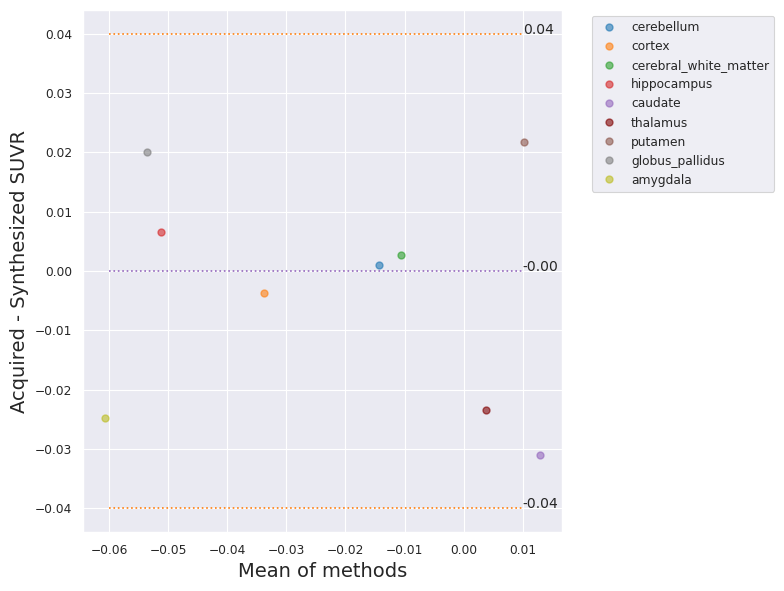

In [226]:
bland_altman_left_right(res, '1p', 'truth', None)

['cerebellum', 'cortex', 'cerebral_white_matter', 'hippocampus', 'caudate', 'thalamus', 'putamen', 'globus_pallidus', 'amygdala'] [-0.013912980293408466, -0.035636525115972074, -0.009307732687908509, -0.04795676397260385, -0.002600778758923031, -0.007938005505638094, 0.020991015038767834, -0.04353740897308796, -0.07305540883595545] [[-0.01481788037819572, -0.031883294302450786, -0.011910057447859345, -0.05457548181969391, 0.028514128109676788, 0.015492309265966472, -0.0006647389084471974, -0.06360386427082657, -0.048255230503947144]]


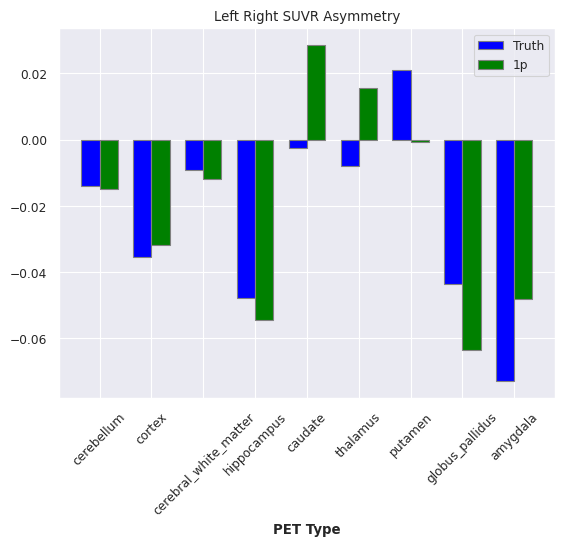

In [211]:
plot_asymmetry(res)

In [194]:
sample_subj = '25013'
seg_file = "/data/jiaqiw01/PET_MRI/data/segmentation/25013/aseg.nii"

global_mask = compute_masks(seg_file)
hemispheric_mask = compute_left_right_masks(seg_file)


In [195]:
pets = {'truth': nib.load('/data/jiaqiw01/preprocessed_cases/25013/reslice_PET_full.nii').get_fdata(),
       '1p': nib.load('/data/jiaqiw01/preprocessed_cases/25013/reslice_PET_1p.nii').get_fdata()}

In [198]:
res, res_diff = compute_asymmetry(hemispheric_mask, global_mask, pets)

{'truth': {'cerebellum': {'left': 0.9856660040500913, 'right': 1.013480084179271, 'diff': -0.013912980293408466}, 'cortex': {'left': 0.9421924665683159, 'right': 1.0118269277925536, 'diff': -0.035636525115972074}, 'cerebral_white_matter': {'left': 1.00846155369953, 'right': 1.0274109103818734, 'diff': -0.009307732687908509}, 'hippocampus': {'left': 0.8193756853753968, 'right': 0.9019236303876498, 'diff': -0.04795676397260385}, 'caudate': {'left': 1.2787955892360108, 'right': 1.2854646628319397, 'diff': -0.002600778758923031}, 'thalamus': {'left': 1.074530412546505, 'right': 1.0917261692191857, 'diff': -0.007938005505638094}, 'putamen': {'left': 1.496227902422628, 'right': 1.434704653072613, 'diff': 0.020991015038767834}, 'globus_pallidus': {'left': 1.0404292444009013, 'right': 1.1351482515967999, 'diff': -0.04353740897308796}, 'amygdala': {'left': 0.7484861107707514, 'right': 0.8664671839689323, 'diff': -0.07305540883595545}}, '1p': {'cerebellum': {'left': 0.9847341455332401, 'right': 

In [199]:
with open("asymmetry.json", 'w') as fw:
    json.dump(res, fw, indent=4)
with open("asymmetry_diff.json", 'w') as fw:
    json.dump(res_diff, fw, indent=4)

In [254]:
combined_suvr_df.style

,subject,pet_type,cerebellum_suvr,cortex_suvr,cerebral_white_matter_suvr,hippocampus_suvr,caudate_suvr,putamen_suvr,brain_stem_suvr,corpus_callosum_suvr,globus_pallidus_suvr,amygdala_suvr
0,23689,truth,1.000000,2.548677,4.103748,0.125274,0.043210,0.061846,0.202116,nan,nan,nan
1,23689,pet_1p,1.000000,3.327634,2.923836,0.085587,0.039651,0.077981,0.060493,nan,nan,nan
2,23689,pet_10p,1.000000,3.020226,3.001812,0.121846,0.049233,0.080170,0.128100,nan,nan,nan
3,24467,truth,1.000000,3.119455,5.214018,0.132587,0.046667,0.055681,0.150069,0.037806,nan,nan
4,24467,pet_1p,1.000000,3.266981,3.653165,0.128881,0.050859,0.061198,0.103049,0.022868,nan,nan
5,24467,pet_10p,1.000000,3.282091,3.643968,0.130899,0.053002,0.065517,0.104923,0.023050,nan,nan
6,24379,truth,1.000000,2.679279,5.044586,0.130529,0.045089,0.079130,0.214377,0.036570,0.037922,0.029003
7,24379,pet_1p,1.000000,3.513166,6.871509,0.153604,0.058560,0.103588,0.270245,0.040427,0.044127,0.033513
8,24379,pet_10p,1.000000,3.470144,6.983485,0.148794,0.058911,0.098832,0.270025,0.044465,0.045686,0.033268
9,20340,truth,1.000000,2.337328,3.802220,0.128182,0.048236,0.062367,0.184151,0.034071,0.027628,0.020443


    cortex_suvr  putamen_suvr  cerebral_white_matter_suvr  brain_stem_suvr  \
10     4.192387      0.091519                    3.364763         0.110749   
1      3.327634      0.077981                    2.923836         0.060493   
7      3.513166      0.103588                    6.871509         0.270245   
4      3.266981      0.061198                    3.653165         0.103049   

    cerebellum_suvr  hippocampus_suvr  caudate_suvr  
10              1.0          0.125108      0.066047  
1               1.0          0.085587      0.039651  
7               1.0          0.153604      0.058560  
4               1.0          0.128881      0.050859  
[4.19238719 3.32763356 3.51316613 3.26698104]
[0.09151941 0.07798076 0.10358832 0.06119753]
[3.36476315 2.92383597 6.87150866 3.65316474]
[0.11074895 0.06049312 0.2702452  0.10304922]
[1. 1. 1. 1.]
[0.12510819 0.08558746 0.15360424 0.12888091]
[0.0660466  0.03965072 0.05855994 0.05085883]
??????
{'cortex': array([4.19238719, 3.32763356, 

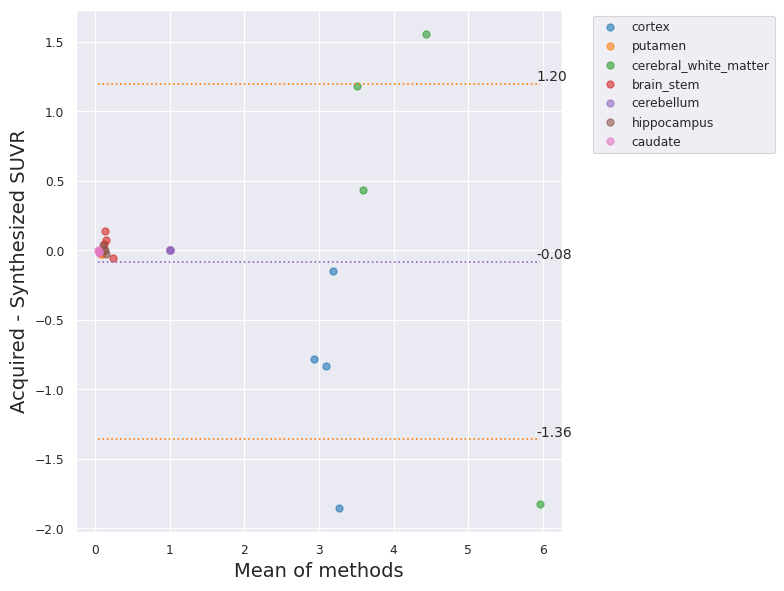

In [259]:
global_bland_altman(combined_suvr_df, 'pet_1p', 'truth', target_rois, "pet_1p_vs_truth.png")

## SUVR with Cerebellum Referencing

In [169]:
def compute_roi_mask(roi_volume_labels, label_vol, shape=(256, 256, 89)):
    roi_mask = np.zeros(shape)
    for lab in roi_volume_labels:
        m = np.where(label_vol==lab, 1, 0)
        roi_mask = m + roi_mask
    return roi_mask

In [181]:
def compute_masks(seg_file, threshold=900):
    label_vol = nib.load(seg_file).get_fdata()

    target_rois = {
        "cerebellum": [7, 8, 46, 47],
        "cortex": [3, 42],
        "cerebral_white_matter": [2, 41],
        "hippocampus": [10, 49],
        "caudate": [11, 50],
        "putamen": [12, 51], 
        "brain_stem": [16],
        "globus_pallidus": [13, 52],
        "amygdala": [18, 54],
        "CSF": [24],
        "corpus_callosum": [251, 252, 253, 254, 255]
    } # cerebral cortex, cerebral wm, hippocampus, caudate, 

    target_volume_maps = {}
    for roi in target_rois.keys():
        val = compute_roi_mask(target_rois[roi], label_vol)
        if np.sum(val) >= threshold:
            target_volume_maps[roi] = val
    return target_volume_maps

In [183]:
shared_rois = None
test_subjects = os.listdir("/home/jiaqiw01/test_cases_10p_conditioned/")
for subj in test_subjects:
    subj_roi_masks = compute_masks(f"/data/jiaqiw01/PET_MRI/data/segmentation/{subj}/aseg.nii")
    if not shared_rois:
        shared_rois = list(subj_roi_masks.keys())
    else:
        shared_rois = list(set(shared_rois) & set(subj_roi_masks.keys()))
        
print(shared_rois)

['cortex', 'putamen', 'cerebral_white_matter', 'brain_stem', 'cerebellum', 'hippocampus', 'caudate']


In [210]:
def compute_suvr(roi_masks, ref_name, pet, include_diff=True): # {pet1: {roi1: {'suvr': xx, ...}}, pet2: {roi1: {'suvr': xx}}}
    ref_mask = roi_masks[ref_name]
    if type(pet) == dict:
        res = {}
        res_diff = {}
        pet_data = pet['truth']
        res['truth'] = {}
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            suv_ref = np.mean(pet_data * ref_mask)
            suv_roi = pet_data * curr_roi_mask
            if suv_ref == 0.0:
                print("Referencing volume is blank.... Skipping")
                return None
            suvr_roi = np.mean(suv_roi / suv_ref) # mean( ROI / mean(cerebellum))
            res['truth'][roi] = {'suvr': suvr_roi}
        for p in pet.keys():
            if p == 'truth':
                continue
            res[p] = {}
            pet_data = pet[p]
            for roi in roi_masks.keys():
                curr_roi_mask = roi_masks[roi]
                suv_ref = np.mean(pet_data * ref_mask)
                suv_roi = pet_data * curr_roi_mask
                if suv_ref == 0.0:
                    print("Referencing volume is blank.... Skipping")
                    return None
                suvr_roi = np.mean(suv_roi / suv_ref) # mean( ROI / mean(cerebellum))
                res[p][roi] = {'suvr': suvr_roi}
                if include_diff:
                    if p not in res_diff:
                        res_diff[p] = {}
                    res_diff[p][roi] = res['truth'][roi]['suvr'] - suvr_roi # how suvr deviates from the true pet
        return res, res_diff
    # just one pet
    else:
        res = {}
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            suv_ref = np.mean(pet * ref_mask)
            suv_roi = np.mean(pet * curr_roi_mask)
            if suv_ref == 0.0:
                print("Referencing volume is blank.... Skipping")
                return None
            suvr_roi = suv_roi / suv_ref
            res[roi] = suvr_roi
        return res

def compute_metrics(roi_masks, res, all_pets):
    import copy
    res2 = copy.deepcopy(res)
    del res2['truth']
    truth = all_pets['truth']
    for pet in all_pets.keys():
        if pet == 'truth':
            continue
        pred_img = all_pets[pet]
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            curr_roi_gt = truth * curr_roi_mask
            curr_roi_pred = pred_img * curr_roi_mask
            psnr = skimage.metrics.peak_signal_noise_ratio(curr_roi_gt, curr_roi_pred, data_range=np.max(curr_roi_gt)-np.min(curr_roi_gt))
            # ssim = skimage.metrics.structural_similarity(curr_roi_gt, curr_roi_pred, data_range=np.max(curr_roi_gt)-np.min(curr_roi_gt))
            rmse = skimage.metrics.normalized_root_mse(curr_roi_gt, curr_roi_pred)
            res2[pet][roi].update({'psnr': psnr, 'rmse': rmse})
    return res2

def json_to_pd_row(subj, res):
    dfs = []
    for k, v in res.items():
        json_v = pd.json_normalize(v, sep='_')
        json_v['pet_type'] = k
        dfs.append(json_v)
    df = pd.concat(dfs, ignore_index=True)
    df['subject'] = subj
    col = df.pop("pet_type")
    df.insert(0, col.name, col)
    col = df.pop("subject")
    df.insert(0, col.name, col)
    return df

In [201]:
pets = {
    "pred_1p": pet_pred_1p,
    "pred_10p": pet_pred_10p,
    "truth": pet_true
}
suvr, suvr_diff = compute_suvr(roi_masks, 'cerebellum', pets)
res = compute_metrics(roi_masks, suvr, pets)
print(suvr_diff)

{'pred_1p': {'cerebellum': 5.551115123125783e-16, 'cortex': -0.08706942297630116, 'cerebral_white_matter': 0.24768576113493612, 'hippocampus': -0.007376687795627723, 'caudate': -0.0013238427998754562, 'putamen': -0.008699008576608241, 'brain_stem': 0.004852842028000348, 'globus_pallidus': 0.0017872696863977869, 'amygdala': -0.0005181296644319253, 'corpus_callosum': 0.005315913109620103}, 'pred_10p': {'cerebellum': 5.551115123125783e-16, 'cortex': -0.04404744889970891, 'cerebral_white_matter': 0.13570980136806465, 'hippocampus': -0.002566552237578068, 'caudate': -0.0016744162083615552, 'putamen': -0.0039422818608035315, 'brain_stem': 0.005072950392720987, 'globus_pallidus': 0.00022813206805678832, 'amygdala': -0.00027317239439841184, 'corpus_callosum': 0.001277897978726246}}


In [202]:
print(suvr)

{'truth': {'cerebellum': {'suvr': 1.0000000000000002}, 'cortex': {'suvr': 3.4260967060235754}, 'cerebral_white_matter': {'suvr': 7.119194424235884}, 'hippocampus': {'suvr': 0.14622755579593144}, 'caudate': {'suvr': 0.05723609287870059}, 'putamen': {'suvr': 0.09488931350174029}, 'brain_stem': {'suvr': 0.275098039197514}, 'globus_pallidus': {'suvr': 0.04591452636121858}, 'amygdala': {'suvr': 0.032994879969946524}, 'corpus_callosum': {'suvr': 0.045742617404053214}}, 'pred_1p': {'cerebellum': {'suvr': 0.9999999999999997}, 'cortex': {'suvr': 3.5131661289998766}, 'cerebral_white_matter': {'suvr': 6.871508663100948}, 'hippocampus': {'suvr': 0.15360424359155916}, 'caudate': {'suvr': 0.05855993567857604}, 'putamen': {'suvr': 0.10358832207834853}, 'brain_stem': {'suvr': 0.2702451971695137}, 'globus_pallidus': {'suvr': 0.04412725667482079}, 'amygdala': {'suvr': 0.03351300963437845}, 'corpus_callosum': {'suvr': 0.04042670429443311}}, 'pred_10p': {'cerebellum': {'suvr': 0.9999999999999997}, 'cortex

In [211]:
suvr_df = json_to_pd_row('23477', suvr)
suvr_df

,subject,pet_type,cerebellum_suvr,cortex_suvr,cerebral_white_matter_suvr,hippocampus_suvr,caudate_suvr,putamen_suvr,brain_stem_suvr,globus_pallidus_suvr,amygdala_suvr,corpus_callosum_suvr
0,23477,truth,1.0,3.426097,7.119194,0.146228,0.057236,0.094889,0.275098,0.045915,0.032995,0.045743
1,23477,pred_1p,1.0,3.513166,6.871509,0.153604,0.058560,0.103588,0.270245,0.044127,0.033513,0.040427
2,23477,pred_10p,1.0,3.470144,6.983485,0.148794,0.058911,0.098832,0.270025,0.045686,0.033268,0.044465


In [155]:
diff_df = pd.DataFrame.from_dict(suvr_diff).reset_index()
diff_df

,index,pred_1p,pred_10p
0,cerebellum,5.551115e-16,5.551115e-16
1,cortex,1.606163e-01,9.166235e-02
2,hippocampus,-7.376688e-03,-2.566552e-03
3,caudate,-1.323843e-03,-1.674416e-03
4,putamen,-8.699009e-03,-3.942282e-03
5,brain_stem,4.852842e-03,5.072950e-03
6,globus_pallidus,1.787270e-03,2.281321e-04
7,amygdala,-5.181297e-04,-2.731724e-04
8,CSF,-8.006213e-04,-3.508295e-04


In [156]:
diff_df_melted = pd.melt(diff_df, id_vars=['index'], value_vars=['pred_1p', 'pred_10p'])

In [157]:
diff_df_melted

,index,variable,value
0,cerebellum,pred_1p,5.551115e-16
1,cortex,pred_1p,1.606163e-01
2,hippocampus,pred_1p,-7.376688e-03
3,caudate,pred_1p,-1.323843e-03
4,putamen,pred_1p,-8.699009e-03
5,brain_stem,pred_1p,4.852842e-03
6,globus_pallidus,pred_1p,1.787270e-03
7,amygdala,pred_1p,-5.181297e-04
8,CSF,pred_1p,-8.006213e-04
9,cerebellum,pred_10p,5.551115e-16


/tmp/ipykernel_1701935/1793090311.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


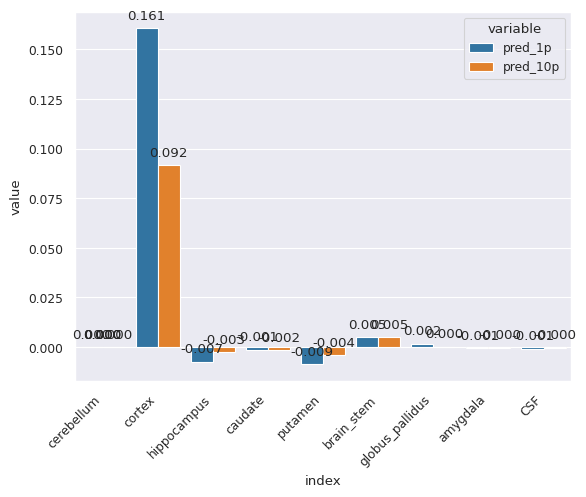

In [164]:
sns.set_context("paper")
sns.set_style("darkgrid")
ax = sns.barplot(diff_df_melted, x='index', y='value', hue='variable')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Annotate each bar with the value
# for p in ax.patches:
#     ax.annotate(format(p.get_height(), '.3f'),
#                 (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 9),  # Offset label above the bar
#                 textcoords = 'offset points')

In [102]:
# import pydicom
# fdg = pydicom.dcmread("/data/jiaqiw01/preprocessed_cases/23477/PET_full/0001.dcm")
# amyloid = pydicom.dcmread("/data/jiaqiw01/preprocessed_cases/24167/PET_full/0001.dcm")

In [145]:
# TRACER_INFO = '/home/jiaqiw01/tracer_info.json'
# subjects = os.listdir("/data/jiaqiw01/preprocessed_cases/")
# subjects2 = os.listdir("/data/jiahong/data/FDG_PET_preprocessed/")
# all_subjects = subjects + subjects2
# tracer_info = {'amyloid': [], 'fdg': []}
# for subj in all_subjects:
#     if len(subj) == 5:
#         pet = list(glob.glob("/data/jiaqiw01/preprocessed_cases/" + subj + "/*PET*/*.dcm"))
#     else:
#         pet = list(glob.glob("/data/jiahong/data/FDG_PET_preprocessed/" + subj + "/*PET*/*.dcm"))
#     if len(pet) == 0:
#         print(f"No pet for {subj}")
#         continue
#     print(f"Using {pet[0]}")
#     dcm = pydicom.dcmread(pet[0])
#     tracer = dcm[0x0009, 0x1037].value
#     tracer2 =dcm[0x0009, 0x1036].value
#     print(tracer, tracer2)
#     if 'amy' in tracer.lower():
#         tracer_info[subj] = 'amyloid'
#         tracer_info['amyloid'].append(subj)
#     elif 'fdg' in tracer.lower() or 'fdg' in tracer2.lower():
#         print("fdg.....")
#         print(tracer)
#         print(tracer2)
#         tracer_info[subj] = 'fdg'
#         tracer_info['fdg'].append(subj)
#     else:
#         print(f"Unknown tracer {tracer} sub {subj}")
#         print(tracer, tracer2)
#         tracer_info[subj] = f'unknown - {tracer}'
# print(tracer_info)

Using /data/jiaqiw01/preprocessed_cases/24733/PET_full/0018.dcm
F18 AMYVID [18F]Florbetapir
Using /data/jiaqiw01/preprocessed_cases/20472/PET_full/0018.dcm
FDG FDG -- fluorodeoxyglucose
fdg.....
FDG
FDG -- fluorodeoxyglucose
Using /data/jiaqiw01/preprocessed_cases/24102/PET_full/0018.dcm
FDG FDG -- fluorodeoxyglucose
fdg.....
FDG
FDG -- fluorodeoxyglucose
Using /data/jiaqiw01/preprocessed_cases/24532/PET_full/0018.dcm
fdg FDG -- fluorodeoxyglucose
fdg.....
fdg
FDG -- fluorodeoxyglucose
Using /data/jiaqiw01/preprocessed_cases/20451/PET_full/0018.dcm
FDG FDG -- fluorodeoxyglucose
fdg.....
FDG
FDG -- fluorodeoxyglucose
Using /data/jiaqiw01/preprocessed_cases/24167/PET_full/0018.dcm
AMYVID Florbetapir
Using /data/jiaqiw01/preprocessed_cases/19215/PET_full/0018.dcm
FDG FDG -- fluorodeoxyglucose
fdg.....
FDG
FDG -- fluorodeoxyglucose
Using /data/jiaqiw01/preprocessed_cases/24297/PET_full/0018.dcm
fdg FDG -- fluorodeoxyglucose
fdg.....
fdg
FDG -- fluorodeoxyglucose
Using /data/jiaqiw01/prepro

In [142]:
sorted(tracer_info['amyloid'])

['24167',
 '24300',
 '24301',
 '24362',
 '24379',
 '24392',
 '24454',
 '24469',
 '24611',
 '24688',
 '24704',
 '24719',
 '24720',
 '24733',
 '24734',
 '24849']

In [146]:
with open(TRACER_INFO, 'w') as fw:
    json.dump(tracer_info, fw, indent=4)

## Plot the best & worst SUVR regions

In [82]:
suvr_df = json_to_pd_row(suvr)
suvr_df

,pet_type,cerebellum_suvr,cortex_suvr,hippocampus_suvr,caudate_suvr,putamen_suvr,brain_stem_suvr,globus_pallidus_suvr,amygdala_suvr,CSF_suvr
0,pred_1p,1.0,10.384675,0.153604,0.058560,0.103588,0.270245,0.044127,0.033513,0.008677
1,pred_10p,1.0,10.453629,0.148794,0.058911,0.098832,0.270025,0.045686,0.033268,0.008227
2,truth,1.0,10.545291,0.146228,0.057236,0.094889,0.275098,0.045915,0.032995,0.007876


In [69]:
df = pd.DataFrame.from_dict(suvr, orient='index')
df['pet_type'] = ['1p', '10p', 'truth']

In [15]:
surv['pred_1p']

In [41]:
df2 = pd.json_normalize(res['pred_1p'], sep='_')
df2

,cerebellum_suvr,cerebellum_psnr,cerebellum_rmse,cerebellum_msssim,cortex_suvr,cortex_psnr,cortex_rmse,cortex_msssim,hippocampus_suvr,hippocampus_psnr,...,globus_pallidus_rmse,globus_pallidus_msssim,amygdala_suvr,amygdala_psnr,amygdala_rmse,amygdala_msssim,CSF_suvr,CSF_psnr,CSF_rmse,CSF_msssim
0,1.0,48.168902,0.11517,0.888,10.384675,39.320203,0.095819,0.888,0.153604,55.162123,...,0.096541,0.888,0.033513,60.547555,0.099885,0.888,0.008677,60.23043,0.190123,0.888


In [87]:
df2 = df.copy()
df2['Subject ID'] = '255555'
df2

,cerebellum,cortex,hippocampus,caudate,putamen,brain_stem,pet_type,Subject ID
pred_1p,1.0,10.384675,0.153604,0.058560,0.103588,0.270245,1p,255555
pred_10p,1.0,10.453629,0.148794,0.058911,0.098832,0.270025,10p,255555
truth,1.0,10.545291,0.146228,0.057236,0.094889,0.275098,truth,255555


In [88]:
df3 = pd.concat([df, df2], ignore_index=True)
df3

,cerebellum,cortex,hippocampus,caudate,putamen,brain_stem,pet_type,Subject ID
0,1.0,10.384675,0.153604,0.058560,0.103588,0.270245,1p,24379
1,1.0,10.453629,0.148794,0.058911,0.098832,0.270025,10p,24379
2,1.0,10.545291,0.146228,0.057236,0.094889,0.275098,truth,24379
3,1.0,10.384675,0.153604,0.058560,0.103588,0.270245,1p,255555
4,1.0,10.453629,0.148794,0.058911,0.098832,0.270025,10p,255555
5,1.0,10.545291,0.146228,0.057236,0.094889,0.275098,truth,255555


In [61]:
def bland_altman_plot(df, target_row=0, truth_row=2):
    roi_names = df.columns
    print(roi_names)
    one_p = df.iloc[target_row, :].values
    truth = df.iloc[truth_row, :].values
    mean = np.mean([one_p, truth], axis=0)
    print(mean)
    diff = one_p - truth
    md = np.mean(diff)  # mean of the differences
    sd = np.std(diff, axis=0)  # standard deviation of the differences

    plt.figure(figsize=(10, 5))
    plot_df = pd.DataFrame({"roi": roi_names, "type": ['1%'] * len(roi_names), "diff_mean": mean, "diff_val": diff})
    
    sns.scatterplot(plot_df, x="diff_mean", y="diff_val", hue="roi")
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.xlabel('Mean of Two Measurements')
    plt.ylabel('Difference Between Measurements')
    plt.title('Bland-Altman Plot')
    plt.show()

Index(['cerebellum', 'cortex', 'hippocampus', 'caudate', 'putamen',
       'brain_stem'],
      dtype='object')
[ 1.         10.46498296  0.1499159   0.05789801  0.09923882  0.27267162]


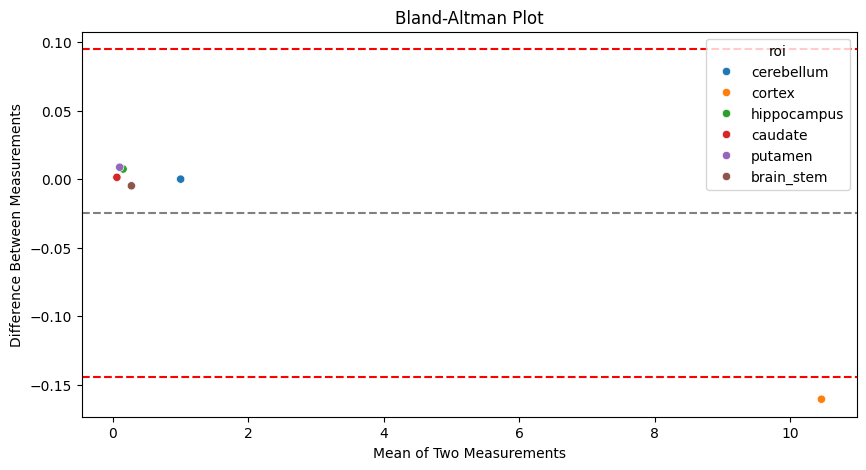

In [62]:
bland_altman_plot(df, 0, 2)

Index(['cerebellum', 'cortex', 'hippocampus', 'caudate', 'putamen',
       'brain_stem'],
      dtype='object')
[ 1.         10.49945995  0.14751083  0.0580733   0.09686045  0.27256156]


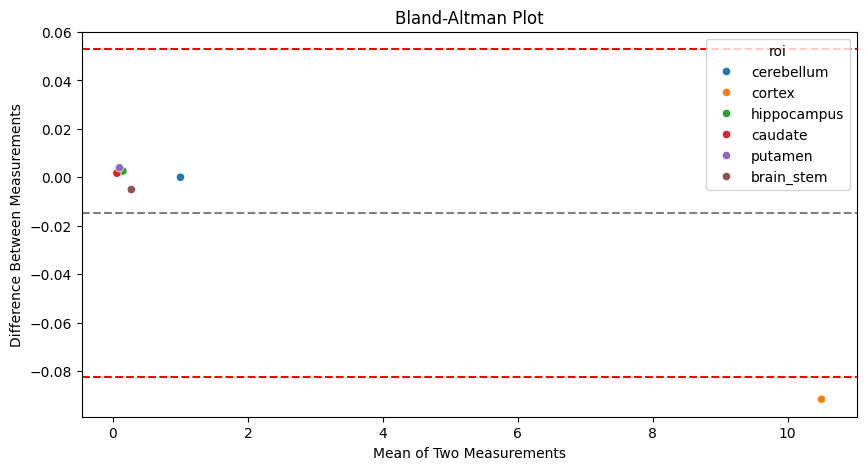

In [63]:
bland_altman_plot(df, 1, 2)

In [214]:
def analyze_one_subj(subj, pet_types, *test_dirs):
    '''
        Computes SUVR, PSNR, RMSE
    '''
    seg_file = os.path.join("/data/jiaqiw01/PET_MRI/data/segmentation", subj, "aseg.nii")
    roi_masks = compute_masks(seg_file)
    pet_truth = sorted(glob.glob(os.path.join("/data/jiaqiw01/preprocessed_cases", subj, 'r2PET_T1*.nii')))
    assert pet_truth is not None
    pet_truth = pet_truth[0]
    pets = {'truth': nib.load(pet_truth).get_fdata()}
    idx = 1
    for i, directory in enumerate(test_dirs):
        pet_data = list(glob.glob(os.path.join(directory, subj) + "/pred.nii"))
        if pet_data == []:
            print("Could not find file name")
            continue
        pets[pet_types[i]] = nib.load(pet_data[0]).get_fdata()
    suvr, suvr_diff = compute_suvr(roi_masks, 'cerebellum', pets, include_diff=True)
    all_metrics = compute_metrics(roi_masks, suvr, pets)
    # print(all_metrics)
    return suvr, suvr_diff, all_metrics

In [215]:
all_suvr_diff_df = []
all_suvr_df = []
all_subj_metrics = {}
for subj in test_subjects:
    print(f"------Performing {subj}--------")
    suvr, suvr_diff, all_metrics =  analyze_one_subj(subj, ['pet_1p', 'pet_10p'], "/home/jiaqiw01/test_cases_1p_conditioned/", "/home/jiaqiw01/test_cases_10p_conditioned/")
    suvr_df = json_to_pd_row(subj, suvr)
    suvr_diff_df = json_to_pd_row(subj, suvr_diff)
    all_suvr_diff_df.append(suvr_diff_df)
    all_suvr_df.append(suvr_df)
    all_subj_metrics[subj] = all_metrics
    print("------Done------")
    
with open('/home/jiaqiw01/test_roi_analysis/test_all_subj_metrics.json', 'w') as fw:
    json.dump(all_subj_metrics, fw, indent=4)

------Performing 23689--------
------Done------
------Performing 24467--------
------Done------
------Performing 24379--------
------Done------
------Performing 20340--------
------Done------


In [216]:
combined_df = pd.concat(all_suvr_df, ignore_index=True)
combined_df.style

,subject,pet_type,cerebellum_suvr,cortex_suvr,cerebral_white_matter_suvr,hippocampus_suvr,caudate_suvr,putamen_suvr,brain_stem_suvr,corpus_callosum_suvr,globus_pallidus_suvr,amygdala_suvr
0,23689,truth,1.000000,2.548677,4.103748,0.125274,0.043210,0.061846,0.202116,nan,nan,nan
1,23689,pet_1p,1.000000,3.327634,2.923836,0.085587,0.039651,0.077981,0.060493,nan,nan,nan
2,23689,pet_10p,1.000000,3.020226,3.001812,0.121846,0.049233,0.080170,0.128100,nan,nan,nan
3,24467,truth,1.000000,3.119455,5.214018,0.132587,0.046667,0.055681,0.150069,0.037806,nan,nan
4,24467,pet_1p,1.000000,3.266981,3.653165,0.128881,0.050859,0.061198,0.103049,0.022868,nan,nan
5,24467,pet_10p,1.000000,3.282091,3.643968,0.130899,0.053002,0.065517,0.104923,0.023050,nan,nan
6,24379,truth,1.000000,2.679279,5.044586,0.130529,0.045089,0.079130,0.214377,0.036570,0.037922,0.029003
7,24379,pet_1p,1.000000,3.513166,6.871509,0.153604,0.058560,0.103588,0.270245,0.040427,0.044127,0.033513
8,24379,pet_10p,1.000000,3.470144,6.983485,0.148794,0.058911,0.098832,0.270025,0.044465,0.045686,0.033268
9,20340,truth,1.000000,2.337328,3.802220,0.128182,0.048236,0.062367,0.184151,0.034071,0.027628,0.020443


In [ ]:
def global_bland_altman(combined_df, target_pet_type, true_pet_type, shared_rois):
    target_cols = [x+"_suvr" for x in shared_rois]
    pet_pred_df = combined_df[combined_df['pet_type'] == target_pet_type].sort_values(by=['subject'])[target_cols]
    pet_true_df = combined_df[combined_df['pet_type'] == true_pet_type].sort_values(by=['subject'])[target_cols]
    suvr_dict_gt_list = []
    suvr_dict_pred_list = []
    suvr_dict_gt = {}
    suvr_dict_pred = {}
    for roi in shared_rois:
        col_val = pet_pred_df[roi+'_suvr'].values
        suvr_dict_pred[roi] = col_val
        suvr_dict_pred_list.extend(col_val)
        col_val = pet_true_df[roi+'_suvr'].values
        suvr_dict_gt[roi] = col_val
        suvr_dict_gt_list.extend(col_val)
        
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
    plt.figure(figsize=(8,6))
    
    for i, lab in enumerate(suvr_dict_gt.keys()):
        plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_list[i], label=lab, markersize=10)
    
    sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean+sd196+0.02, "%.2f" % (mean+sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean-sd196+0.02, "%.2f" % (mean-sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
    plt.legend(ncol=2)
    plt.text(xmax-0.05, mean+0.02, "%.2f" % mean, fontsize=10)
    plt.xlabel('Mean of methods', fontsize=14)
    plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
    # plt.savefig('global_bland_altman.png')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust the plot to make room for the legend
    plt.tight_layout()
    plt.show()
    

,cortex_suvr,putamen_suvr,cerebral_white_matter_suvr,brain_stem_suvr,cerebellum_suvr,hippocampus_suvr,caudate_suvr
10,4.192387,0.091519,3.364763,0.110749,1.000000,0.125108,0.066047
1,3.327634,0.077981,2.923836,0.060493,1.000000,0.085587,0.039651
7,3.513166,0.103588,6.871509,0.270245,1.000000,0.153604,0.058560
4,3.266981,0.061198,3.653165,0.103049,1.000000,0.128881,0.050859


In [227]:
pet_true_df.style

,cortex_suvr,putamen_suvr,cerebral_white_matter_suvr,brain_stem_suvr,cerebellum_suvr,hippocampus_suvr,caudate_suvr
9,2.337328,0.062367,3.802220,0.184151,1.000000,0.128182,0.048236
0,2.548677,0.061846,4.103748,0.202116,1.000000,0.125274,0.043210
6,2.679279,0.079130,5.044586,0.214377,1.000000,0.130529,0.045089
3,3.119455,0.055681,5.214018,0.150069,1.000000,0.132587,0.046667


In [239]:
suvr_dict_gt_list = []
suvr_dict_pred_list = []
suvr_dict_gt = {}
suvr_dict_pred = {}
for roi in shared_rois:
    col_val = pet_1p_df[roi+'_suvr'].values
    suvr_dict_pred[roi] = col_val
    suvr_dict_pred_list.extend(col_val)
    col_val = pet_true_df[roi+'_suvr'].values
    suvr_dict_gt[roi] = col_val
    suvr_dict_gt_list.extend(col_val)
suvr_dict_gt_list, suvr_dict_gt

([2.3373280960145397,
  2.5486768672154954,
  2.6792786015485426,
  3.119455456103121,
  0.06236677150690059,
  0.06184621310717448,
  0.07913009684511162,
  0.05568094125790355,
  3.8022198312419397,
  4.103748058838893,
  5.044585630198153,
  5.214018340310962,
  0.1841514264872327,
  0.20211649748184055,
  0.21437744034566444,
  0.15006922871040582,
  0.9999999999999999,
  1.0000000000000004,
  1.0000000000000002,
  1.0000000000000004,
  0.12818224700184735,
  0.1252741608840526,
  0.13052907158909496,
  0.1325867319949972,
  0.048236357385632554,
  0.04320968862970668,
  0.04508937635917131,
  0.04666737707516244],
 {'cortex': array([2.3373281 , 2.54867687, 2.6792786 , 3.11945546]),
  'putamen': array([0.06236677, 0.06184621, 0.0791301 , 0.05568094]),
  'cerebral_white_matter': array([3.80221983, 4.10374806, 5.04458563, 5.21401834]),
  'brain_stem': array([0.18415143, 0.2021165 , 0.21437744, 0.15006923]),
  'cerebellum': array([1., 1., 1., 1.]),
  'hippocampus': array([0.12818225, 

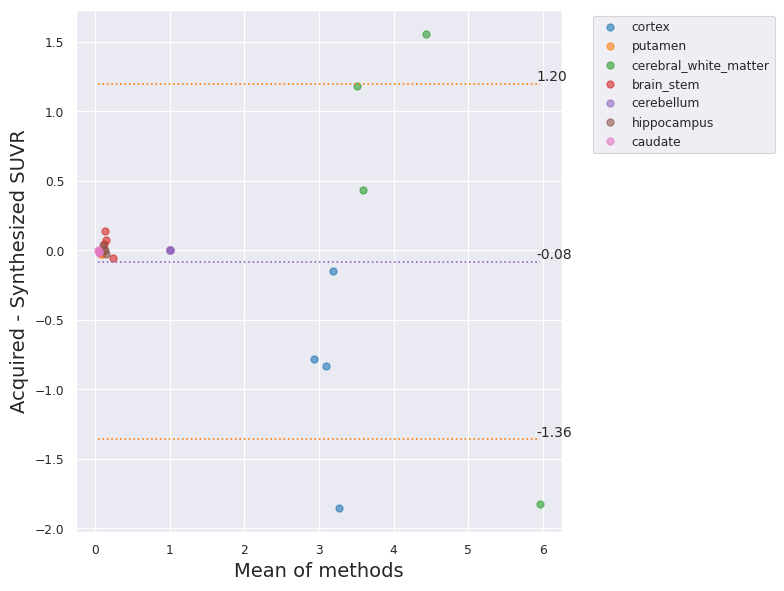

In [249]:
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
plt.figure(figsize=(8,6))

for i, lab in enumerate(suvr_dict_gt.keys()):
    plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_list[i], label=lab, markersize=10)

sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
plt.text(xmax-0.05, mean+sd196+0.02, "%.2f" % (mean+sd196), fontsize=10)
plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
plt.text(xmax-0.05, mean-sd196+0.02, "%.2f" % (mean-sd196), fontsize=10)
plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
plt.legend(ncol=2)
plt.text(xmax-0.05, mean+0.02, "%.2f" % mean, fontsize=10)
plt.xlabel('Mean of methods', fontsize=14)
plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
# plt.savefig('global_bland_altman.png')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Adjust the plot to make room for the legend
plt.tight_layout()
plt.show()

In [234]:
for roi in shared_rois:
    target_col = roi + "_suvr"
    pred_cortex = pet_1p_df[target_col].values
    true_cortex = pet_true_df[target_col].values
    mean = (pred_cortex + true_cortex) / 2
    print(mean)
    diff = pred_cortex - true_cortex
    print(diff)
    md = np.mean(diff)  # mean of the differences
    sd = np.std(diff)  # standard deviation of the differences
    print(md, sd)

[3.26485764 2.93815521 3.09622237 3.19321825]
[1.8550591  0.77895669 0.83388753 0.14752558]
0.9038572231548707 0.6118248235873114


In [225]:
def bland_altman_plot(df_pred, df_true, shared_rois):
    roi_names = shared_rois
    print(roi_names)
    mean = (df_pred + df_true) / 2
    print(mean)
    diff = df_pred - df_true
    md = np.mean(diff.values)  # mean of the differences
    sd = np.std(diff, axis=0)  # standard deviation of the differences

    plt.figure(figsize=(10, 5))
    plot_df = pd.DataFrame({"roi": roi_names, "type": ['1%'] * len(roi_names), "diff_mean": mean, "diff_val": diff})
    
    sns.scatterplot(plot_df, x="diff_mean", y="diff_val", hue="roi")
    plt.axhline(md, color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red', linestyle='--')
    plt.axhline(md - 1.96*sd, color='red', linestyle='--')
    plt.xlabel('Mean of Two Measurements')
    plt.ylabel('Difference Between Measurements')
    plt.title('Bland-Altman Plot')
    plt.show()

['cortex_suvr',
 'putamen_suvr',
 'cerebral_white_matter_suvr',
 'brain_stem_suvr',
 'cerebellum_suvr',
 'hippocampus_suvr',
 'caudate_suvr']

In [ ]:
# plt.figure(figsize=(20, 10))
fig, axs = plt.subplots(3,4,figsize=(20, 10))
fig.tight_layout(pad=2.5)
idx = -1
for lab in suvr_dict_gt.keys():
    idx += 1
    ridx = idx // 4
    cidx = idx % 4
#     print(lab, (label_mask == lab).sum())
    
    axs[ridx, cidx].plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color='tab:blue')
    sd196 = round(1.96*np.std(np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab])), 2)
    mean = round(np.mean(np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab])), 2)
    xmin = round(0.5*np.min(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), 2)
    xmax = round(0.5*np.max(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), 2)
    
    axs[ridx, cidx].plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
    axs[ridx, cidx].text(xmax, mean+sd196, "%.2f" % (mean+sd196), fontsize=14)
    axs[ridx, cidx].plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
    axs[ridx, cidx].text(xmax, mean-sd196, "%.2f" % (mean-sd196), fontsize=14)
    axs[ridx, cidx].plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
    axs[ridx, cidx].text(xmax, mean, "%.2f" % mean, fontsize=14)
    axs[ridx, cidx].set_title(region_combined_dict[lab]+', '+str((label_mask_combined == lab).sum()), fontsize=14)
#     axs[ridx, cidx].xlabel('Mean of methods', fontsize=14)
#     axs[ridx, cidx].ylabel('Ground-truth - Synthesized SUVR', fontsize=14)
#     break
plt.savefig('region_bland_altman.png')
    

In [ ]:
suvr_dict_gt_list = []
suvr_dict_pred_list = []
for lab in suvr_dict_gt.keys():
    suvr_dict_gt_list.extend(suvr_dict_gt[lab])
    suvr_dict_pred_list.extend(suvr_dict_pred[lab])
suvr_dict_pred_list = np.array(suvr_dict_pred_list)
suvr_dict_gt_list = np.array(suvr_dict_gt_list)


In [ ]:
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
plt.figure(figsize=(8,6))

for lab in suvr_dict_gt.keys():
    plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_list[lab], label=region_combined_dict[lab])

sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
plt.text(xmax-0.05, mean+sd196+0.02, "%.2f" % (mean+sd196), fontsize=14)
plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
plt.text(xmax-0.05, mean-sd196+0.02, "%.2f" % (mean-sd196), fontsize=14)
plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
plt.legend(ncol=2)
plt.text(xmax-0.05, mean+0.02, "%.2f" % mean, fontsize=14)
plt.xlabel('Mean of methods', fontsize=14)
plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
plt.savefig('global_bland_altman.png')


In [74]:
# List of subject dictionaries with subject IDs
subjects = [
    {'subject_id': 'subject1', **subject1},
    {'subject_id': 'subject2', **subject2},
    {'subject_id': 'subject3', **subject3}
]

# Combine dictionaries into a DataFrame
df = pd.DataFrame(subjects)

# Print the DataFrame
print(df)

NameError: name 'subject1' is not defined

In [141]:
subj = '24379'
example_1p = f"/data/jiaqiw01/test_cases_1p_conditioned/{subj}/pred.nii"
example_10p = f"/data/jiaqiw01/test_cases_10p_conditioned/{subj}/pred.nii"
example_full = f"/data/jiaqiw01/test_cases_1p_conditioned/{subj}/target.nii"

mask_file = "/data/jiaqiw01/PET_MRI/data/segmentation_masks.h5"
def recursively_load_dict_contents_from_group(h5file, path):
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]  # Convert dataset to numpy array or scalar
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, f"{path}/{key}")
    return ans
with h5py.File(mask_file, 'r') as h5file:
    res = recursively_load_dict_contents_from_group(h5file, '/')

In [6]:
arr_1p = nib.load(example_1p).get_fdata()
arr_10p = nib.load(example_10p).get_fdata()
arr_full = nib.load(example_full).get_fdata()
mask = res[subj]
arr_1p.shape

(256, 256, 89)

In [8]:
mask['20']

{'Brain-Stem': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'sum': 53},
 'Left-Cerebellum-Cortex': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'sum': 631},
 'Right-Cerebellum-Cortex': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'sum': 693}}

## Select slice whose ROI intensity on T1 is the highest

In [144]:
for roi in rois:
    print(roi)
    d = info[roi][subj]
    best = sorted(d.items(), key=lambda x: x[1], reverse=True)
    print(best[0])
    best_slice = int(best[0][0])
    print(best_slice)

Left-Cerebral-White-Matter
('50', 3234)
50
Right-Cerebral-White-Matter
('49', 3194)
49


In [ ]:
for subj_id in subj_id_list:
    gt_img = nib.load(os.path.join(nifti_path, subj_id+'_PET.nii')).get_fdata()
    pred_img = nib.load(os.path.join(nifti_path, subj_id+'_pred.nii')).get_fdata()
#     gt_img = gt_img[:,:,20:-20]
#     pred_img = pred_img[:,:,20:-20]
#     ASL_img = nib.load(os.path.join(nifti_path, subj_id+'_ASL.nii')).get_fdata()
    psnr_list.append(skimage.metrics.peak_signal_noise_ratio(gt_img, pred_img, data_range=np.max(gt_img)-np.min(gt_img)))
    ssim_list.append(skimage.metrics.structural_similarity(gt_img, pred_img, data_range=np.max(gt_img)-np.min(gt_img)))
    rmse_list.append(skimage.metrics.normalized_root_mse(gt_img, pred_img))
    print(psnr_list[-1], ssim_list[-1], rmse_list[-1])

print('PSNR:', np.mean(psnr_list), np.std(psnr_list))
print('SSIM:', np.mean(ssim_list), np.std(ssim_list))
print('RMSE:', np.mean(rmse_list), np.std(rmse_list))

In [ ]:
## See it on PET

In [145]:
mask_roi1 = mask[str(best_slice)][roi1]['mask']
mask_roi2 = mask[str(best_slice)][roi2]['mask']
dim_mask = np.where(mask_roi1==0, 0.5, 1)
dim_mask2 = np.where(mask_roi2==0, 0.5, 1)

In [146]:
pet_1p_slice = arr_1p[:, :, best_slice]
pet_10p_slice = arr_10p[:, :, best_slice]
pet_full_slice = arr_full[:, :, best_slice]

pets = [pet_1p_slice, pet_10p_slice, pet_full_slice]

In [148]:
# prepare all slices
all_slices = []
for roi in rois:
    mask_roi = mask[str(best_slice)][roi]['mask']
    dim_mask = np.where(mask_roi==0, 0.5, 1)
    # add pet_1p
    val = pet_1p_slice * dim_mask
    all_slices.append(val)
    val = pet_10p_slice * dim_mask
    all_slices.append(val)
    val = pet_full_slice * dim_mask
    all_slices.append(val)

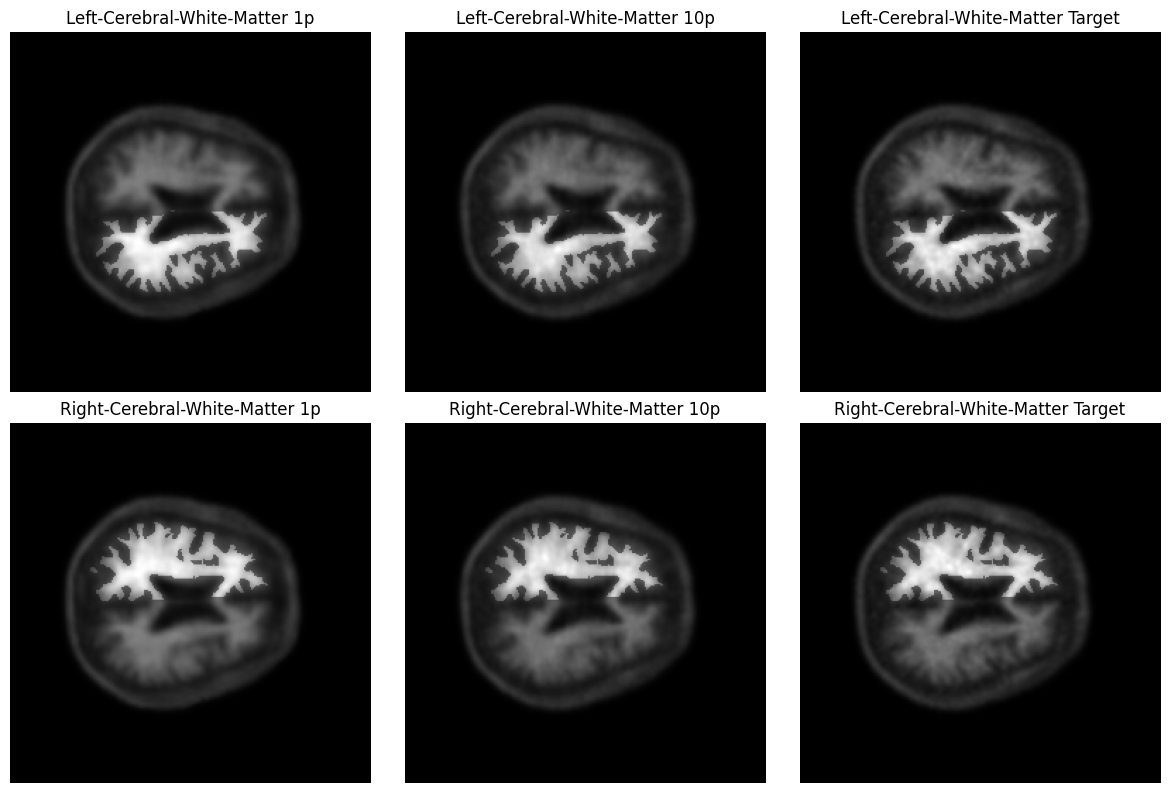

In [149]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    roi_name = rois[int(i/3)]
    if i % 3 == 0:
        dl = '1p'
    elif i % 3 == 1:
        dl = '10p'
    else:
        dl = 'Target'
    title = f"{roi_name} {dl}"
    ax.imshow(all_slices[i], cmap='gray') 
    ax.set_title(title)
    ax.axis('off')  # Turn off the axis

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.savefig("left_cwm_comparison.png", dpi=300)

In [54]:
## Stats
for roi in rois:
    print(roi)
    mask_roi = mask[str(best_slice)][roi]['mask']
    # add pet_1p
    val1 = pet_1p_slice * mask_roi
    val2 = pet_10p_slice * mask_roi
    val3 = pet_full_slice * mask_roi

    target_z = np.mean(val3) / np.std(val3)
    pred_z_10p = np.mean(val2) / np.std(val2)
    pred_z_1p = np.mean(val1) / np.std(val1)
    print(target_z, pred_z_10p, pred_z_1p)

Left-Cerebral-White-Matter
0.2131508185839981 0.21307576880106618 0.2126042972743739
Right-Cerebral-White-Matter
0.2217248063378326 0.22191361206738744 0.22182261248813004


## Z score for all ROI and compare

In [150]:
all_rois = info.keys()
selected_rois = []
selected_slices = []
for roi in all_rois:
    print(roi)
    d = info[roi][subj]
    best = sorted(d.items(), key=lambda x: x[1], reverse=True)
    if best == []:
        continue
    best_slice = int(best[0][0])
    # choose the middle ones
    # if best_slice >= 40 and best_slice <= 60:
    selected_rois.append(roi)
    selected_slices.append(best_slice)
    print("Selected..")
    print(best_slice)

Left-Cerebral-White-Matter
Selected..
50
Left-Cerebral-Cortex
Selected..
32
Left-Lateral-Ventricle
Selected..
49
Left-Inf-Lat-Vent
Selected..
37
Left-Cerebellum-White-Matter
Selected..
29
Left-Cerebellum-Cortex
Selected..
23
Left-Thalamus
Selected..
43
Left-Caudate
Selected..
49
Left-Putamen
Selected..
44
Left-Pallidum
Selected..
43
3rd-Ventricle
Selected..
42
4th-Ventricle
Selected..
29
Brain-Stem
Selected..
34
Left-Hippocampus
Selected..
37
Left-Amygdala
Selected..
38
CSF
Selected..
45
Left-Accumbens-area
Left-VentralDC
Selected..
40
Left-vessel
Left-choroid-plexus
Right-Cerebral-White-Matter
Selected..
49
Right-Cerebral-Cortex
Selected..
46
Right-Lateral-Ventricle
Selected..
49
Right-Inf-Lat-Vent
Right-Cerebellum-White-Matter
Selected..
28
Right-Cerebellum-Cortex
Selected..
23
Right-Thalamus
Selected..
43
Right-Caudate
Selected..
49
Right-Putamen
Selected..
43
Right-Pallidum
Selected..
44
Right-Hippocampus
Selected..
36
Right-Amygdala
Selected..
37
Right-Accumbens-area
Selected..
44

In [151]:
selected_rois, selected_slices

(['Left-Cerebral-White-Matter',
  'Left-Cerebral-Cortex',
  'Left-Lateral-Ventricle',
  'Left-Inf-Lat-Vent',
  'Left-Cerebellum-White-Matter',
  'Left-Cerebellum-Cortex',
  'Left-Thalamus',
  'Left-Caudate',
  'Left-Putamen',
  'Left-Pallidum',
  '3rd-Ventricle',
  '4th-Ventricle',
  'Brain-Stem',
  'Left-Hippocampus',
  'Left-Amygdala',
  'CSF',
  'Left-VentralDC',
  'Right-Cerebral-White-Matter',
  'Right-Cerebral-Cortex',
  'Right-Lateral-Ventricle',
  'Right-Cerebellum-White-Matter',
  'Right-Cerebellum-Cortex',
  'Right-Thalamus',
  'Right-Caudate',
  'Right-Putamen',
  'Right-Pallidum',
  'Right-Hippocampus',
  'Right-Amygdala',
  'Right-Accumbens-area',
  'Right-VentralDC',
  'WM-hypointensities'],
 [50,
  32,
  49,
  37,
  29,
  23,
  43,
  49,
  44,
  43,
  42,
  29,
  34,
  37,
  38,
  45,
  40,
  49,
  46,
  49,
  28,
  23,
  43,
  49,
  43,
  44,
  36,
  37,
  44,
  39,
  52])

In [152]:
import sklearn.metrics
import skimage.metrics
import skimage
def compute_reconstruction_metrics_single(target, pred):
    # target = target / target.max() + 1e-8
    # pred = pred / pred.max() + 1e-8
    # range = np.max(target) - np.min(target)
    # pdb.set_trace()
    target = target - target.min()
    pred = pred - pred.min()
    range = target.max()
    try:
        rmse_pred = skimage.metrics.mean_squared_error(target, pred)
        # rmse_pred = skimage.metrics.normalized_root_mse(target, pred)
    except Exception as e:
        print(e)
        rmse_pred = float('nan')
    try:
        # psnr_pred = skimage.metrics.peak_signal_noise_ratio(target, pred)
        psnr_pred = skimage.metrics.peak_signal_noise_ratio(target, pred, data_range=range)
    except Exception as e:
        print(e)
        psnr_pred = float('nan')
    try:
        # ssim_pred = skimage.metrics.structural_similarity(target, pred)
        ssim_pred = skimage.metrics.structural_similarity(target, pred, data_range=range)
    except Exception as e:
        print(e)
        ssim_pred = float('nan')
    return {'ssim': ssim_pred, 'rmse': rmse_pred, 'psnr': psnr_pred}

In [185]:
target_zs = []
pred_zs_10 = []
pred_zs_1 = []
rmse_10 = []
rmse_1 = []
psnr_10 = []
psnr_1 = []
ssim_10 = []
ssim_1 = []
names = []
name_LUT = {}
for i, roi in enumerate(selected_rois):
    print(roi)
    short_name = [x[0] for x in roi.split('-')]
    if short_name != []:
        short_name = ''.join(short_name)
    else:
        short_name = roi
    if short_name == 'LCWM' or short_name == 'RCWM' or short_name == 'RCC':
        continue
    name_LUT[short_name] = roi
    print(short_name)
    names.append(short_name)
    best_slice = selected_slices[i]
    mask_roi = mask[str(best_slice)][roi]['mask']
    area = mask[str(best_slice)][roi]['sum']
    pet_1p_slice = arr_1p[:, :, best_slice]
    pet_10p_slice = arr_10p[:, :, best_slice]
    pet_full_slice = arr_full[:, :, best_slice]
    
    val1 = pet_1p_slice * mask_roi
    val2 = pet_10p_slice * mask_roi
    val3 = pet_full_slice * mask_roi
    res10p = compute_reconstruction_metrics_single(val3, val2)
    res1p = compute_reconstruction_metrics_single(val3, val1)

    psnr_10.append(res10p['psnr'] / area)
    psnr_1.append(res1p['psnr'] / area)

    rmse_10.append(res10p['rmse'] / area)
    rmse_1.append(res1p['rmse'] / area)

    ssim_10.append(res10p['ssim'])
    ssim_1.append(res1p['ssim'])

    target_z = np.mean(val3) / np.std(val3)
    pred_z_10p = np.mean(val2) / np.std(val2)
    pred_z_1p = np.mean(val1) / np.std(val1)
    print(target_z, pred_z_10p, pred_z_1p)
    target_zs.append(target_z)
    pred_zs_10.append(pred_z_10p)
    pred_zs_1.append(pred_z_1p)

Left-Cerebral-White-Matter
Left-Cerebral-Cortex
LCC
0.09893066440006525 0.09882523685172873 0.09898576431617342
Left-Lateral-Ventricle
LLV
0.07228125227016925 0.07224376227480096 0.0721006463292648
Left-Inf-Lat-Vent
LILV


KeyError: 'Left-Inf-Lat-Vent'

In [154]:
df = pd.DataFrame({'roi': names, 'target_z': target_zs, 'pred_z_10p': pred_zs_10, 'pred_z_1p': pred_zs_1, 
                  'rmse_10p': rmse_10, 'rmse_1p': rmse_1, 'psnr_10p': psnr_10, 'psnr_1p': psnr_1,
                  'ssim_10p': ssim_10, 'ssim_1p': ssim_1})
# melted_df = pd.melt(df, id_vars=['roi'], value_vars=['target_z', 'pred_z_10p', 'pred_z_1p'])
# melted_df
sub_df = df[['roi', 'rmse_10p', 'rmse_1p', 'psnr_10p', 'psnr_1p', 'ssim_10p', 'ssim_1p']]
df

,roi,target_z,pred_z_10p,pred_z_1p,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
0,LCC,0.162860,0.163255,0.163475,1701.967401,2867.096227,41.767368,39.502458,0.999377,0.998899
1,LLV,0.087902,0.089675,0.088900,608.803288,780.943715,45.656434,44.575007,0.998922,0.999162
2,LILV,0.029273,0.029244,0.029217,17.693146,89.626074,61.601154,54.554860,0.999995,0.999975
3,LCC,0.137140,0.137877,0.137643,1579.965665,2160.237570,42.021537,40.662999,0.996846,0.996597
4,LT,0.065379,0.065644,0.066041,472.931497,1276.740895,49.737131,45.424085,0.999787,0.999566
5,LC,0.046302,0.046165,0.046327,49.935425,163.571455,57.610462,52.457475,0.999984,0.999959
6,LP,0.051818,0.052179,0.052269,204.769154,1032.089370,53.271629,46.247101,0.999960,0.999848
7,LP,0.044825,0.044895,0.045139,123.504409,532.070664,55.132812,48.789943,0.999972,0.999889
8,3V,0.049794,0.050193,0.049224,71.152668,106.956087,49.062299,47.292156,0.999857,0.999841
9,4V,0.032969,0.032996,0.033265,59.220281,79.449947,54.313208,53.036976,0.999969,0.999959


In [155]:
melted_df = sub_df.melt(id_vars=['roi'], value_vars=['rmse_10p', 'rmse_1p', 'psnr_10p', 'psnr_1p', 'ssim_10p', 'ssim_1p'])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, 'LCC'),
  Text(1, 0, 'LLV'),
  Text(2, 0, 'LILV'),
  Text(3, 0, 'LT'),
  Text(4, 0, 'LC'),
  Text(5, 0, 'LP'),
  Text(6, 0, '3V'),
  Text(7, 0, '4V'),
  Text(8, 0, 'BS'),
  Text(9, 0, 'LH'),
  Text(10, 0, 'LA'),
  Text(11, 0, 'C'),
  Text(12, 0, 'LV'),
  Text(13, 0, 'RLV'),
  Text(14, 0, 'RT'),
  Text(15, 0, 'RC'),
  Text(16, 0, 'RP'),
  Text(17, 0, 'RH'),
  Text(18, 0, 'RA'),
  Text(19, 0, 'RAa'),
  Text(20, 0, 'RV'),
  Text(21, 0, 'Wh')])

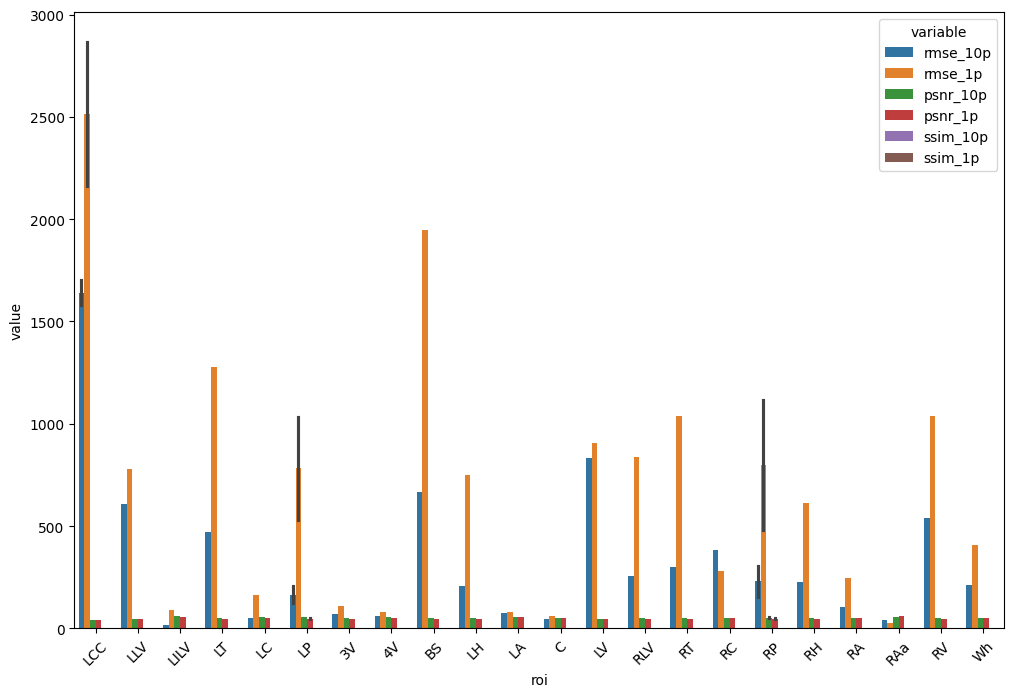

In [156]:
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(melted_df, x='roi', y='value', hue='variable')
# maxi = np.max(target_zs)+0.005
# mini = np.min(target_zs)-0.005
plt.xticks(rotation=45)
# plt.ylim(mini, maxi)

In [100]:
name_LUT

{'LCC': 'Left-Cerebellum-Cortex',
 'LLV': 'Left-Lateral-Ventricle',
 'LILV': 'Left-Inf-Lat-Vent',
 'LT': 'Left-Thalamus',
 'LC': 'Left-Caudate',
 'LP': 'Left-Pallidum',
 '3V': '3rd-Ventricle',
 '4V': '4th-Ventricle',
 'BS': 'Brain-Stem',
 'LH': 'Left-Hippocampus',
 'LA': 'Left-Amygdala',
 'C': 'CSF',
 'LV': 'Left-VentralDC',
 'RLV': 'Right-Lateral-Ventricle',
 'RT': 'Right-Thalamus',
 'RC': 'Right-Caudate',
 'RP': 'Right-Pallidum',
 'RH': 'Right-Hippocampus',
 'RA': 'Right-Amygdala',
 'RAa': 'Right-Accumbens-area',
 'RV': 'Right-VentralDC',
 'Wh': 'WM-hypointensities'}

In [101]:
df

,roi,target_z,pred_z_10p,pred_z_1p
0,LCC,0.162860,0.163255,0.163475
1,LLV,0.087902,0.089675,0.088900
2,LILV,0.029273,0.029244,0.029217
3,LCC,0.137140,0.137877,0.137643
4,LT,0.065379,0.065644,0.066041
5,LC,0.046302,0.046165,0.046327
6,LP,0.051818,0.052179,0.052269
7,LP,0.044825,0.044895,0.045139
8,3V,0.049794,0.050193,0.049224
9,4V,0.032969,0.032996,0.033265


In [104]:
df['target-10p'] = abs(df['target_z'] - df['pred_z_10p'])
df['target-1p'] = abs(df['target_z'] - df['pred_z_1p'])
df

,roi,target_z,pred_z_10p,pred_z_1p,target-10p,target-1p
0,LCC,0.162860,0.163255,0.163475,0.000395,0.000614
1,LLV,0.087902,0.089675,0.088900,0.001773,0.000998
2,LILV,0.029273,0.029244,0.029217,0.000029,0.000056
3,LCC,0.137140,0.137877,0.137643,0.000737,0.000503
4,LT,0.065379,0.065644,0.066041,0.000266,0.000662
5,LC,0.046302,0.046165,0.046327,0.000138,0.000025
6,LP,0.051818,0.052179,0.052269,0.000361,0.000451
7,LP,0.044825,0.044895,0.045139,0.000070,0.000314
8,3V,0.049794,0.050193,0.049224,0.000399,0.000570
9,4V,0.032969,0.032996,0.033265,0.000027,0.000297


In [105]:
sorted_by_diff_10p = df.sort_values(by=['target-10p'])
sorted_by_diff_10p

,roi,target_z,pred_z_10p,pred_z_1p,target-10p,target-1p
14,LV,0.064522,0.064512,0.064914,0.000009,0.000392
23,RV,0.063100,0.063089,0.062983,0.000011,0.000116
20,RH,0.068437,0.068420,0.068704,0.000017,0.000267
9,4V,0.032969,0.032996,0.033265,0.000027,0.000297
2,LILV,0.029273,0.029244,0.029217,0.000029,0.000056
12,LA,0.038413,0.038363,0.038133,0.000050,0.000281
7,LP,0.044825,0.044895,0.045139,0.000070,0.000314
11,LH,0.071054,0.070957,0.070429,0.000097,0.000626
13,C,0.044651,0.044768,0.044857,0.000117,0.000207
24,Wh,0.057732,0.057865,0.057695,0.000133,0.000036


In [107]:
sorted_by_diff_11p = df.sort_values(by=['target-1p'])
sorted_by_diff_11p

,roi,target_z,pred_z_10p,pred_z_1p,target-10p,target-1p
19,RP,0.039923,0.040124,0.039927,0.000201,0.000004
15,RLV,0.081575,0.081194,0.081600,0.000381,0.000024
5,LC,0.046302,0.046165,0.046327,0.000138,0.000025
24,Wh,0.057732,0.057865,0.057695,0.000133,0.000036
2,LILV,0.029273,0.029244,0.029217,0.000029,0.000056
21,RA,0.042925,0.042692,0.043031,0.000233,0.000106
23,RV,0.063100,0.063089,0.062983,0.000011,0.000116
22,RAa,0.031498,0.031214,0.031340,0.000284,0.000157
16,RT,0.066249,0.066781,0.066077,0.000532,0.000172
13,C,0.044651,0.044768,0.044857,0.000117,0.000207


In [135]:
sub_df.sort_values(by=['ssim_10p'],ascending=False).iloc[:10 :]

,roi,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
2,LILV,17.693146,89.626074,61.601154,54.554860,0.999995,0.999975
5,LC,49.935425,163.571455,57.610462,52.457475,0.999984,0.999959
22,RAa,39.259728,27.505425,57.186664,58.731953,0.999983,0.999990
7,LP,123.504409,532.070664,55.132812,48.789943,0.999972,0.999889
19,RP,152.210488,482.426647,54.778615,49.768748,0.999979,0.999942
9,4V,59.220281,79.449947,54.313208,53.036976,0.999969,0.999959
12,LA,75.304474,82.171240,53.872005,53.493015,0.999950,0.999952
6,LP,204.769154,1032.089370,53.271629,46.247101,0.999960,0.999848
21,RA,106.758940,244.131536,52.811799,49.219602,0.999872,0.999845
16,RT,301.224863,1039.352070,52.109552,46.730833,0.999854,0.999732


In [139]:
sub_df['rmse_diff'] = abs(sub_df['rmse_1p'] - sub_df['rmse_10p'])
sub_df.sort_values(by=['rmse_diff'], ascending=False).iloc[:10, :].drop(columns=['ssim_10p', 'ssim_1p'])

/tmp/ipykernel_1361511/3276243938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df['rmse_diff'] = abs(sub_df['rmse_1p'] - sub_df['rmse_10p'])


,roi,rmse_10p,rmse_1p,psnr_10p,psnr_1p,rmse_diff
10,BS,664.819278,1948.432223,49.317002,44.647185,1283.612945
0,LCC,1701.967401,2867.096227,41.767368,39.502458,1165.128826
6,LP,204.769154,1032.089370,53.271629,46.247101,827.320216
18,RP,307.069928,1115.101228,51.523971,45.923201,808.031300
4,LT,472.931497,1276.740895,49.737131,45.424085,803.809398
16,RT,301.224863,1039.352070,52.109552,46.730833,738.127208
15,RLV,256.066231,837.780103,48.724492,43.576715,581.713871
3,LCC,1579.965665,2160.237570,42.021537,40.662999,580.271905
11,LH,204.717613,748.268471,51.428769,45.799746,543.550858
23,RV,537.208683,1038.161605,48.877413,46.016194,500.952922


In [187]:
def calculate_normalized_psnr(original, reconstructed, area):
    height, width = original.shape
    mse = np.mean((original - reconstructed) ** 2)
    normalized_mse = mse / area
    if normalized_mse == 0:
        return float('inf')
    max_pixel_value = 255.0  # Assuming 8-bit images
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(normalized_mse))
    return psnr

In [189]:
import sklearn.metrics
import skimage.metrics
import skimage
def compute_reconstruction_metrics_single(target, pred, area):
    # target = target / target.max() + 1e-8
    # pred = pred / pred.max() + 1e-8
    # range = np.max(target) - np.min(target)
    # pdb.set_trace()
    target = target - target.min()
    pred = pred - pred.min()
    range = target.max()
    try:
        rmse_pred = skimage.metrics.mean_squared_error(target, pred) / area
        # rmse_pred = skimage.metrics.normalized_root_mse(target, pred)
    except Exception as e:
        print(e)
        rmse_pred = float('nan')
    try:
        # psnr_pred = skimage.metrics.peak_signal_noise_ratio(target, pred)
        psnr_pred = calculate_normalized_psnr(target, pred, area)
    except Exception as e:
        print(e)
        psnr_pred = float('nan')
    try:
        # ssim_pred = skimage.metrics.structural_similarity(target, pred)
        ssim_pred = skimage.metrics.structural_similarity(target, pred, data_range=range)
    except Exception as e:
        print(e)
        ssim_pred = float('nan')
    return {'ssim': ssim_pred, 'rmse': rmse_pred, 'psnr': psnr_pred}

In [190]:
def roi_metrics_for_one_subj(subj, info, arr_1p, arr_10p, arr_full, mask):
    all_rois = info.keys()
    selected_rois = []
    selected_slices = []
    for roi in all_rois:
        # print(roi)
        d = info[roi][subj]
        best = sorted(d.items(), key=lambda x: x[1], reverse=True)
        if best == []:
            continue
        best_slice = int(best[0][0])
        # choose the middle ones
        # if best_slice >= 40 and best_slice <= 60:
        selected_rois.append(roi)
        selected_slices.append(best_slice)
        print(f"Selected slice {best_slice} for {roi}")
    target_zs = []
    pred_zs_10 = []
    pred_zs_1 = []
    rmse_10 = []
    rmse_1 = []
    psnr_10 = []
    psnr_1 = []
    ssim_10 = []
    ssim_1 = []
    names = []
    name_LUT = {}
    for i, roi in enumerate(selected_rois):
        print(roi)
        short_name = [x[0] for x in roi.replace("-", "_").split('_')]
        if short_name != []:
            short_name = ''.join(short_name)
        else:
            short_name = roi
        if short_name == 'LCWM' or short_name == 'RCWM' or short_name == 'RCC':
            continue
        name_LUT[short_name] = roi
        print(short_name)
        names.append(short_name)
        best_slice = selected_slices[i]
        mask_roi = mask[str(best_slice)][roi]['mask']
        area = mask[str(best_slice)][roi]['sum']
        
        pet_1p_slice = arr_1p[:, :, best_slice]
        pet_10p_slice = arr_10p[:, :, best_slice]
        pet_full_slice = arr_full[:, :, best_slice]
        
        val1 = pet_1p_slice * mask_roi
        val2 = pet_10p_slice * mask_roi
        val3 = pet_full_slice * mask_roi
        res10p = compute_reconstruction_metrics_single(val3, val2, area)
        res1p = compute_reconstruction_metrics_single(val3, val1, area)

        psnr_10.append(res10p['psnr'])
        psnr_1.append(res1p['psnr'])
    
        rmse_10.append(res10p['rmse'])
        rmse_1.append(res1p['rmse'])
    
        ssim_10.append(res10p['ssim'])
        ssim_1.append(res1p['ssim'])
    
        target_z = np.mean(val3) / np.std(val3)
        pred_z_10p = np.mean(val2) / np.std(val2)
        pred_z_1p = np.mean(val1) / np.std(val1)
        # print(target_z, pred_z_10p, pred_z_1p)
        target_zs.append(target_z)
        pred_zs_10.append(pred_z_10p)
        pred_zs_1.append(pred_z_1p)
    return target_zs, pred_zs_1, pred_zs_10, rmse_1, rmse_10, psnr_1, psnr_10, ssim_1, ssim_10, names, name_LUT

In [162]:
mask_file = "/data/jiaqiw01/PET_MRI/data/segmentation_masks.h5"
def recursively_load_dict_contents_from_group(h5file, path):
    ans = {}
    for key, item in h5file[path].items():
        if isinstance(item, h5py._hl.dataset.Dataset):
            ans[key] = item[()]  # Convert dataset to numpy array or scalar
        elif isinstance(item, h5py._hl.group.Group):
            ans[key] = recursively_load_dict_contents_from_group(h5file, f"{path}/{key}")
    return ans
with h5py.File(mask_file, 'r') as h5file:
    all_masks = recursively_load_dict_contents_from_group(h5file, '/')

## Compute for all test subjects

In [191]:
subjects = os.listdir("/data/jiaqiw01/test_cases_10p_conditioned/")
result_dir = "/data/jiaqiw01/test_cases_10p_conditioned/"
result_dir2 = "/data/jiaqiw01/test_cases_1p_conditioned/"
all_target_zs = []
all_pred_zs_10 = []
all_pred_zs_1 = []
all_rmse_10 = []
all_rmse_1 = []
all_psnr_10 = []
all_psnr_1 = []
all_ssim_10 = []
all_ssim_1 = []
all_names = []
name_LUT = {}
all_subjects = []
with open("/data/jiaqiw01/PET_MRI/data/roi_intensity_info.json", 'r') as fr:
    info = json.load(fr)

for subj in subjects:
    arr_1p = nib.load(os.path.join(result_dir2, subj, "pred.nii")).get_fdata()
    arr_10p = nib.load(os.path.join(result_dir, subj, "pred.nii")).get_fdata()
    arr_full = nib.load(os.path.join(result_dir2, subj, "target.nii")).get_fdata()
    if subj not in all_masks:
        continue
    mask = all_masks[subj]
    try:
        target_zs, pred_zs_1, pred_zs_10, rmse_1, rmse_10, psnr_1, psnr_10, ssim_1, ssim_10, names, name_LUT = roi_metrics_for_one_subj(subj, info, arr_1p, arr_10p, arr_full, mask)
    except Exception as e:
        print(e)
        continue
    all_target_zs.extend(target_zs)
    all_pred_zs_10.extend(pred_zs_10)
    all_pred_zs_1.extend(pred_zs_1)
    all_rmse_10.extend(rmse_10)
    all_rmse_1.extend(rmse_1)
    all_psnr_10.extend(psnr_10)
    all_psnr_1.extend(psnr_1)
    all_ssim_10.extend(ssim_1)
    all_ssim_1.extend(ssim_10)
    all_names.extend(names)
    all_subjects.extend([subj]*len(names))

assert len(all_target_zs) == len(all_names)


Selected slice 50 for Left-Cerebral-White-Matter
Selected slice 32 for Left-Cerebral-Cortex
Selected slice 49 for Left-Lateral-Ventricle
Selected slice 37 for Left-Inf-Lat-Vent
Selected slice 29 for Left-Cerebellum-White-Matter
Selected slice 23 for Left-Cerebellum-Cortex
Selected slice 43 for Left-Thalamus
Selected slice 49 for Left-Caudate
Selected slice 44 for Left-Putamen
Selected slice 43 for Left-Pallidum
Selected slice 42 for 3rd-Ventricle
Selected slice 29 for 4th-Ventricle
Selected slice 34 for Brain-Stem
Selected slice 37 for Left-Hippocampus
Selected slice 38 for Left-Amygdala
Selected slice 45 for CSF
Selected slice 40 for Left-VentralDC
Selected slice 49 for Right-Cerebral-White-Matter
Selected slice 46 for Right-Cerebral-Cortex
Selected slice 49 for Right-Lateral-Ventricle
Selected slice 28 for Right-Cerebellum-White-Matter
Selected slice 23 for Right-Cerebellum-Cortex
Selected slice 43 for Right-Thalamus
Selected slice 49 for Right-Caudate
Selected slice 43 for Right-Put

In [192]:
len(all_subjects), len(all_names), len(all_target_zs)

(100, 100, 100)

In [193]:
all_subj_metrics_df = pd.DataFrame({'subject_id': all_subjects, 'roi': all_names, 'target_z': all_target_zs, 
                                    'pred_z_10p': all_pred_zs_10, 'pred_z_1p': all_pred_zs_1, 
                                    'rmse_10p': all_rmse_10, 'rmse_1p': all_rmse_1, 
                                    'psnr_10p': all_psnr_10, 'psnr_1p': all_psnr_1,
                                    'ssim_10p': all_ssim_10, 'ssim_1p': all_ssim_1})

In [194]:
all_subj_metrics_df.style

,subject_id,roi,target_z,pred_z_10p,pred_z_1p,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
0,24379,LCC,0.162860,0.162999,0.163327,1.181743,2.023722,47.405574,45.069296,0.998657,0.999242
1,24379,LLV,0.087902,0.089680,0.090921,1.224304,1.932831,47.251910,45.268866,0.998904,0.998698
2,24379,LILV,0.029273,0.029254,0.029300,0.355384,2.099451,52.623819,44.909745,0.999973,0.999996
3,24379,LCC,0.137140,0.137563,0.137990,1.410458,2.533644,46.637203,44.093348,0.995589,0.996445
4,24379,LT,0.065379,0.065454,0.066437,1.509086,5.077023,46.343665,41.074712,0.999554,0.999786
5,24379,LC,0.046302,0.046154,0.046539,0.443253,1.502875,51.664285,46.361575,0.999940,0.999978
6,24379,LP,0.051818,0.052196,0.052360,1.350693,7.330432,46.825236,39.479508,0.999804,0.999952
7,24379,LP,0.044825,0.044791,0.045222,1.327959,6.135460,46.898958,40.252332,0.999828,0.999955
8,24379,3V,0.049794,0.050342,0.049742,0.526294,0.431779,50.918516,51.778183,0.999871,0.999841
9,24379,4V,0.032969,0.032901,0.033413,1.232962,1.679445,47.221306,45.879147,0.999943,0.999951


In [195]:
all_subj_metrics_df.to_csv("roi_metrics_transunet.csv")

In [196]:
all_subj_metrics_df.sort_values(by=['rmse_10p']).style

,subject_id,roi,target_z,pred_z_10p,pred_z_1p,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
2,24379,LILV,0.029273,0.029254,0.029300,0.355384,2.099451,52.623819,44.909745,0.999973,0.999996
5,24379,LC,0.046302,0.046154,0.046539,0.443253,1.502875,51.664285,46.361575,0.999940,0.999978
8,24379,3V,0.049794,0.050342,0.049742,0.526294,0.431779,50.918516,51.778183,0.999871,0.999841
15,24379,RLV,0.081575,0.081196,0.081780,0.621738,2.831839,50.194732,43.610118,0.998809,0.999496
22,24379,RAa,0.031498,0.031165,0.031221,0.624434,1.547947,50.175940,46.233241,0.999969,0.999983
13,24379,C,0.044651,0.044556,0.044988,0.663690,1.967384,49.911153,45.191912,0.999805,0.999919
20,24379,RH,0.068437,0.068416,0.069008,0.789952,3.127961,49.154797,43.178191,0.999000,0.999680
11,24379,LH,0.071054,0.070910,0.070548,0.828939,2.574479,48.945578,44.023910,0.999161,0.999408
16,24379,RT,0.066249,0.066471,0.066319,0.979118,4.162031,48.222453,41.937751,0.999719,0.999846
12,24379,LA,0.038413,0.038376,0.038159,1.069799,1.155785,47.837783,47.502034,0.999937,0.999932


In [202]:
from IPython.display import display
for subj in subjects:
    print(subj)
    subj_df = all_subj_metrics_df[all_subj_metrics_df['subject_id']==subj]
    sorted_subj_df = subj_df.sort_values(by=['rmse_10p'])
    display(sorted_subj_df.iloc[0, :].to_frame().transpose())

24379


,subject_id,roi,target_z,pred_z_10p,pred_z_1p,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
2,24379,LILV,0.029273,0.029254,0.0293,0.355384,2.099451,52.623819,44.909745,0.999973,0.999996


23689


,subject_id,roi,target_z,pred_z_10p,pred_z_1p,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
26,23689,LLV,0.066582,0.066513,0.060992,3.17878,300.125951,43.108198,23.357768,0.99552,0.999908


20340


,subject_id,roi,target_z,pred_z_10p,pred_z_1p,rmse_10p,rmse_1p,psnr_10p,psnr_1p,ssim_10p,ssim_1p
65,20340,RLV,0.044059,0.04401,0.04489,2.408349,19.521406,44.31361,35.225693,0.999898,0.999984


24849


IndexError: single positional indexer is out-of-bounds